In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from torch.autograd import Variable
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,BertModel
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional
import transformers

np.random.RandomState(seed=1)

/Users/nzaretski/opt/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


RandomState(MT19937) at 0x17777E240

# Проверка моделей

Метрика: модели будут сортироваться по roc_auc_score, так как эта метрика не зависит от threshold. Затем будет максимизироваться precision и f1-score, так как для бизнес задачи более выгодно не удалить фейковый комментарий, приняв его за реальный, чем удалить чей-то реальный комментарий, приняв его за фейковый.

Будут рассматриваться базовые catboost, LogRegression, SVM с разным набором входных данных

In [2]:
# результаты обучения каждой модели будут записываться в results
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', '2*roc_auc-1', 'thrs', 'predicted'])
def evaluation(model_name, val, predicted, thrs=0.5):
    '''
    На вход - имя модели, метки, получившиеся после обучения модели, и метки валидационной выборки
    Возвращает таблицу с результатами results + столбец predicted с предсказаниями модели для валидационного датасета 
    (для сохранения данных)
    '''
    
    acc = metrics.accuracy_score(val, (predicted>thrs))
    pr = metrics.precision_score(val, (predicted>thrs))
    rec = metrics.recall_score(val, (predicted>thrs))
    f1 = metrics.f1_score(val, (predicted>thrs))
    roc_auc = metrics.roc_auc_score(val, predicted)
    roc_norm = roc_auc * 2 - 1
    
    results.loc[len(results)] = [model_name, acc, pr, rec, f1, roc_auc, roc_norm, thrs, predicted]

    
def plot(model_name, predicted, val, thrs=0.5):
    '''
    Рисует для конкретной модели roc и предсказания модели
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(val, predicted)
    
    A = np.array(predicted)
    idx_sig = np.where(val == 1)[0]
    idx_bkg = np.where(val == 0)[0]
    bins = 10
    
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    plt.plot(fpr,  tpr, '.')
    plt.title(model_name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    ax2 = plt.subplot(1,2,2)
    plt.hist(A[idx_sig], histtype='step', label='1', density=True, bins = bins)
    plt.hist(A[idx_bkg], histtype='step', label='0', density=True, bins = bins)
    plt.vlines(x=thrs, ymin=0, ymax=4, color='red', linestyle='--', label = 'threshold')
    plt.xlabel('prediction')
    plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
    plt.legend(loc="upper right")
    plt.title(model_name)
    plt.show()
    plt.close('all') 


In [3]:
def models(model_feature, x_train, y_train, x_val, y_val, thrs=0.5):
    '''
    Функция обучает 3 модели (с произвольными параметрами) на данных, результаты по валидации добавляются в таблицу results
    '''
    #1. Catboost
    print('---Catboost---')
    model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=10, silent=True)
    model.fit(x_train, y_train)
    preds_proba = model.predict_proba(x_val)
    preds_proba1 = preds_proba[:, 1]
    evaluation(model_feature + '_catboost_', y_val, preds_proba1, thrs)
    
    #2. SVM
    print('---SVM---')
    model = svm.SVC(probability=True)
    model.fit(x_train, y_train)
    preds_proba = model.predict_proba(x_val)
    preds_proba1 = preds_proba[:, 1]
    evaluation(model_feature + '_SVM_', y_val, preds_proba1, thrs)
    
    #3. Logistic regression
    print('---Logistic regression---')
    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(x_train, y_train)
    preds_proba = model.predict_proba(x_val)
    preds_proba1 = preds_proba[:, 1]
    evaluation(model_feature + '_LogisticRegr', y_val, preds_proba1, thrs)    

In [4]:
def plot_results():
    '''
    Рисует для всех моделей из results roc и предсказания
    '''
    preds = results.predicted.values
    name = results.model.values
    thrs = results.thrs.values
    for i in range(len(results)):
        plot(str(i) + ':' + name[i], preds[i], y_val, thrs[i])

In [5]:
#убираем дубликаты и id
data = pd.read_csv('/Users/nzaretski/Desktop/education/wildberies/script/wb_school/data/data_analysis.csv')
data = data[data.duplicated() == False].reset_index(drop=True)
data.drop(['id1', 'id2', 'id3'], axis=1, inplace=True)
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1


In [6]:
#checkpoint
data_in = data.copy()

In [7]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [8]:
df_train.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,"Хорошая мыльница,крышка плотно закрывается.",25,25,4.840000,17,0,4.294118,51,56,0
1,Для работы отлично.,15,15,4.133333,6,0,4.500000,14,37,0


# 1. Baseline

In [9]:
# id1 - покупатель
# id2 - товар
# id3 - продавец
# f1 - количество отзывов (id1)
# f2 - (id1)
# f3 - средний отзыв пользователя(id1)
# f4 - количество продаж (id2)
# f5 - количество фото в комментариях(id2)
# f6 - средняя оценка товара (id2)
# f7 - количество выкупов
# f8 - количество заказов


#f7 / f8 - доля выкупа

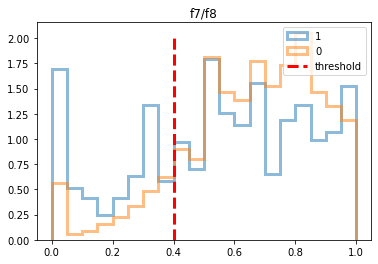

In [10]:
plt.hist(data.f7[data.label==1] / data.f8[data.label==1], bins=20, alpha=0.5, label='1', density=True, histtype = 'step', linewidth=3)
plt.hist(data.f7[data.label==0] / data.f8[data.label==0], bins=20, alpha=0.5, label='0', density=True, histtype = 'step', linewidth=3)
plt.vlines(x=0.4, ymin=0, ymax=2, color='red', linewidth=3, linestyle='--', label='threshold')
plt.legend()
plt.title('f7/f8')
plt.show()

In [11]:
y = df_val.label.values
preds = df_val.f7 / df_val.f8 < 0.4
preds = np.array(preds.replace({False:0, True:1}))

In [12]:
evaluation('baseline', y, preds)
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,baseline,0.722222,0.451613,0.225806,0.301075,0.563485,0.126969,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
# это лучше, чем просто проставление 0 всем данным

# 2. Числовые признаки
## 2.1 f1-f8

In [14]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


In [15]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,baseline,0.722222,0.451613,0.225806,0.301075,0.563485,0.126969,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,num_f1_f8_catboost_,0.771368,0.680851,0.258065,0.374269,0.729393,0.458787,0.5,"[0.16608701972375936, 0.20303623628171774, 0.1..."
2,num_f1_f8_SVM_,0.741453,0.714286,0.040323,0.076336,0.702738,0.405476,0.5,"[0.2548184167319622, 0.25151893022067534, 0.25..."
3,num_f1_f8_LogisticRegr,0.777778,0.884615,0.185484,0.306667,0.728127,0.456255,0.5,"[0.2381657169963737, 0.06286272026182388, 0.22..."


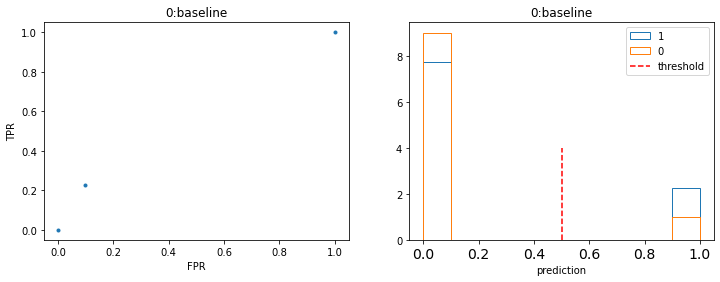

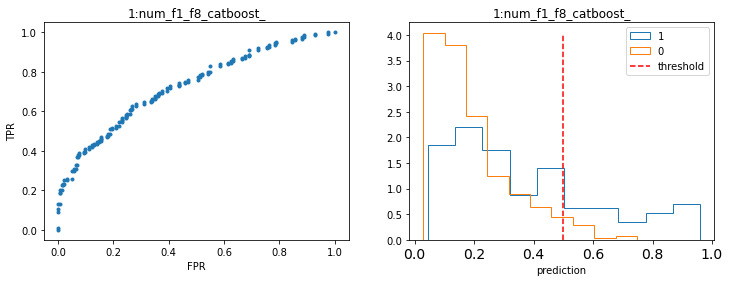

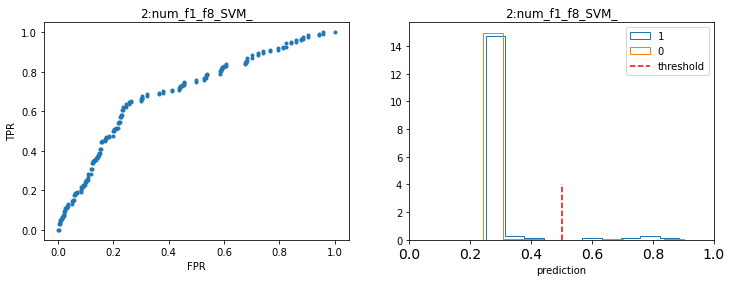

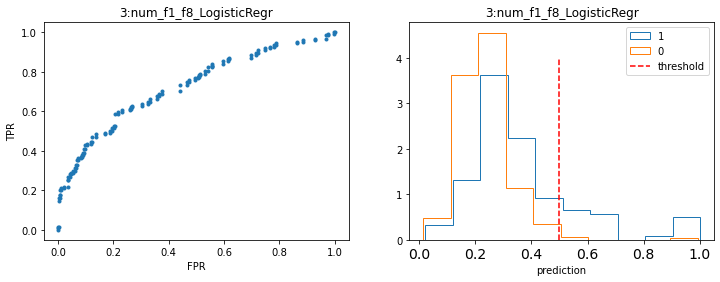

In [16]:
plot_results()

## 2.2 Добавим перемножения признаков f1-f8 (включая перемножения с самим собой)

In [17]:
cols = list(data.columns)
cols.remove('label')
cols.remove('text')
print(cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']


In [18]:
for i in range(len(cols)):
    for j in range(i, len(cols)):
        name1 = 'mult_' + cols[i] + '_' + cols[j]
        data[name1] = data[cols[i]] * data[cols[j]]

In [19]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,mult_f5_f5,mult_f5_f6,mult_f5_f7,mult_f5_f8,mult_f6_f6,mult_f6_f7,mult_f6_f8,mult_f7_f7,mult_f7_f8,mult_f8_f8
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,169,55.545455,234,468,18.256198,76.909091,153.818182,324,648,1296
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,16,17.739130,360,436,19.667297,399.130435,483.391304,8100,9810,11881


In [20]:
#checkpoint
data_mult = data.copy()

In [21]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [22]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_+mult', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


In [23]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,baseline,0.722222,0.451613,0.225806,0.301075,0.563485,0.126969,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,num_f1_f8_catboost_,0.771368,0.680851,0.258065,0.374269,0.729393,0.458787,0.5,"[0.16608701972375936, 0.20303623628171774, 0.1..."
2,num_f1_f8_SVM_,0.741453,0.714286,0.040323,0.076336,0.702738,0.405476,0.5,"[0.2548184167319622, 0.25151893022067534, 0.25..."
3,num_f1_f8_LogisticRegr,0.777778,0.884615,0.185484,0.306667,0.728127,0.456255,0.5,"[0.2381657169963737, 0.06286272026182388, 0.22..."
4,num_f1_f8_+mult_catboost_,0.775641,0.702128,0.266129,0.385965,0.727143,0.454285,0.5,"[0.1460968838746284, 0.18534616981706423, 0.17..."
5,num_f1_f8_+mult_SVM_,0.737179,0.666667,0.016129,0.031496,0.575089,0.150178,0.5,"[0.2582552336805791, 0.25820729052221036, 0.25..."
6,num_f1_f8_+mult_LogisticRegr,0.750000,0.733333,0.088710,0.158273,0.665580,0.331161,0.5,"[0.4651661098652345, 0.05139169996279914, 0.33..."


## 2.3 Добавим к исходным f1-f8 попарные деления признаков f1-f8 друг на друга

In [24]:
data = data_in.copy()
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1


In [25]:
cols = list(data.columns)
cols.remove('label')
cols.remove('text')
print(cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']


In [26]:
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        #деление не выполняется на признак с нулевыми значениями
        if len(data[cols[j]][data[cols[j]]==0].values) == 0:
            name = 'div_' + cols[i] + '_' + cols[j]
            data[name] = data[cols[i]] / data[cols[j]]

In [27]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f2_f8,div_f3_f4,div_f3_f6,div_f3_f8,div_f4_f6,div_f4_f8,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,0.027778,0.090909,0.234043,0.027778,2.574468,0.305556,3.042553,0.361111,0.118687,0.500000
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,0.055046,0.058696,0.608824,0.024771,10.372549,0.422018,0.901961,0.036697,0.040686,0.825688


In [28]:
#checkpoint
data_div = data.copy()

In [29]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [30]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_+div', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


In [31]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,baseline,0.722222,0.451613,0.225806,0.301075,0.563485,0.126969,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,num_f1_f8_catboost_,0.771368,0.680851,0.258065,0.374269,0.729393,0.458787,0.5,"[0.16608701972375936, 0.20303623628171774, 0.1..."
2,num_f1_f8_SVM_,0.741453,0.714286,0.040323,0.076336,0.702738,0.405476,0.5,"[0.2548184167319622, 0.25151893022067534, 0.25..."
3,num_f1_f8_LogisticRegr,0.777778,0.884615,0.185484,0.306667,0.728127,0.456255,0.5,"[0.2381657169963737, 0.06286272026182388, 0.22..."
4,num_f1_f8_+mult_catboost_,0.775641,0.702128,0.266129,0.385965,0.727143,0.454285,0.5,"[0.1460968838746284, 0.18534616981706423, 0.17..."
5,num_f1_f8_+mult_SVM_,0.737179,0.666667,0.016129,0.031496,0.575089,0.150178,0.5,"[0.2582552336805791, 0.25820729052221036, 0.25..."
6,num_f1_f8_+mult_LogisticRegr,0.750000,0.733333,0.088710,0.158273,0.665580,0.331161,0.5,"[0.4651661098652345, 0.05139169996279914, 0.33..."
7,num_f1_f8_+div_catboost_,0.784188,0.709091,0.314516,0.435754,0.759143,0.518286,0.5,"[0.09426697959804306, 0.18868648292749332, 0.1..."
8,num_f1_f8_+div_SVM_,0.741453,0.714286,0.040323,0.076336,0.669988,0.339976,0.5,"[0.25267037458801195, 0.2504123037367064, 0.25..."
9,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."


## 2.4 Добавим умножение и деление f1-f8

In [32]:
data = data_in.copy()


for i in range(len(cols)):
    name1 = 'mult_' + cols[i] + '_' + cols[i]
    data[name1] = data[cols[i]] * data[cols[i]]
    for j in range(i+1, len(cols)):
        if len(data[cols[j]][data[cols[j]]==0].values) == 0:
            name = 'div_' + cols[i] + '_' + cols[j]
            data[name] = data[cols[i]] / data[cols[j]]
        name1 = 'mult_' + cols[i] + '_' + cols[j]
        data[name1] = data[cols[i]] * data[cols[j]]

In [33]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f5_f8,mult_f5_f8,mult_f6_f6,mult_f6_f7,div_f6_f8,mult_f6_f8,mult_f7_f7,div_f7_f8,mult_f7_f8,mult_f8_f8
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,0.361111,468,18.256198,76.909091,0.118687,153.818182,324,0.500000,648,1296
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,0.036697,436,19.667297,399.130435,0.040686,483.391304,8100,0.825688,9810,11881


In [34]:
#checkpoint
data_mult_div = data.copy()

In [35]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [36]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_+div+mult', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


In [37]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,baseline,0.722222,0.451613,0.225806,0.301075,0.563485,0.126969,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,num_f1_f8_catboost_,0.771368,0.680851,0.258065,0.374269,0.729393,0.458787,0.5,"[0.16608701972375936, 0.20303623628171774, 0.1..."
2,num_f1_f8_SVM_,0.741453,0.714286,0.040323,0.076336,0.702738,0.405476,0.5,"[0.2548184167319622, 0.25151893022067534, 0.25..."
3,num_f1_f8_LogisticRegr,0.777778,0.884615,0.185484,0.306667,0.728127,0.456255,0.5,"[0.2381657169963737, 0.06286272026182388, 0.22..."
4,num_f1_f8_+mult_catboost_,0.775641,0.702128,0.266129,0.385965,0.727143,0.454285,0.5,"[0.1460968838746284, 0.18534616981706423, 0.17..."
5,num_f1_f8_+mult_SVM_,0.737179,0.666667,0.016129,0.031496,0.575089,0.150178,0.5,"[0.2582552336805791, 0.25820729052221036, 0.25..."
6,num_f1_f8_+mult_LogisticRegr,0.750000,0.733333,0.088710,0.158273,0.665580,0.331161,0.5,"[0.4651661098652345, 0.05139169996279914, 0.33..."
7,num_f1_f8_+div_catboost_,0.784188,0.709091,0.314516,0.435754,0.759143,0.518286,0.5,"[0.09426697959804306, 0.18868648292749332, 0.1..."
8,num_f1_f8_+div_SVM_,0.741453,0.714286,0.040323,0.076336,0.669988,0.339976,0.5,"[0.25267037458801195, 0.2504123037367064, 0.25..."
9,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."


# 3. Добавление текстовых параметров
Параметры, которые можно достать из текста: количество знаков препинания, средняя длина слова в комментарии, количество слов в комментарии, процент слов, начинающихся с большой буквы, среднее количество знаков препинания в пересчете на количество слов

In [54]:
data = data_in.copy()
data.drop(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'], axis=1, inplace=True)
data.head(2)

,text,label
0,"Хотела купить на замену старых,по итогу эти у...",0
1,Запах по сравнению с обычным DOVE никакой. Оно...,1


In [55]:
# количество знаков препининия
data['num_points'] = data.text.apply(lambda x: x.count(',') + x.count(';') \
                                   + x.count(':')+ x.count('.')+ x.count('!')+ x.count('?')\
                                   + x.count('"')+ x.count("'")+ x.count('/'))

In [56]:
# убираем знаки препинания и все, кроме русского текста
from string import digits, whitespace
import re

cyrillic_letters = "абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"

def tokenizer(text):
    text = text.replace(',', ' ')
    text = text.replace(':', ' ')
    text = text.replace(';', ' ')
    text = text.replace('.', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('"', ' ')
    text = text.replace("'", ' ')
    text = text.replace('/', ' ')
    allowed_chars = cyrillic_letters + digits + whitespace
    return re.sub("\s\s+", " ", "".join([c for c in text if c in allowed_chars])).strip()

# data.text = data.text.apply(lambda x: tokenizer(x.lower()))
data.text = data.text.apply(lambda x: tokenizer(x))

In [57]:
#количество слов, начинающихся с большой буквы
def big_letter(x):
    counter = 0
    for word in x.split():
        if word[0].upper() == word[0]:
            counter+=1
    return counter

data['num_big_letters'] = data.text.apply(lambda x: big_letter(x))
data.text = data.text.apply(lambda x: x.lower())

In [58]:
# средняя длина слова, количество слов
def avg_word_len(x): # x - string
    x = x.split()
    lens = []
    if len(x) == 0:
        return 0
    for i in x:
        lens.append(len(i))
    return np.mean(lens)

data['avg_word_len'] = data.text.apply(avg_word_len)
data['num_words'] = data.text.apply(lambda x: len(x.split()))

In [59]:
# пустые комментарии после "чистки" 
data[data.num_words==0]

,text,label,num_points,num_big_letters,avg_word_len,num_words
23,,1,0,0,0.0,0
407,,1,0,0,0.0,0
636,,0,0,0,0.0,0
1217,,0,0,0,0.0,0
2298,,1,0,0,0.0,0


In [60]:
data['avg_big_letters'] = data.num_big_letters / data.num_words
data['avg_points'] = data.num_points / data.num_words

# так как комментарий может быть пустой, появятся nan при вычислении средних - заменим их нулями
data = data.fillna(0)

In [64]:
cols = list(data.columns)
cols.remove('text')
cols.remove('label')

In [65]:
data_text = data.copy()

In [66]:
data_text1 = data_text.copy()

In [67]:
data_text.head(2)

,text,label,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points
0,хотела купить на замену старых по итогу эти уж...,0,5,1,4.750000,16,0.062500,0.312500
1,запах по сравнению с обычным никакой оно не па...,1,2,3,5.642857,14,0.214286,0.142857


## 3.1 Добавление текстовых параметров к f1-f8

In [68]:
data = data_in.copy()
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1


In [69]:
data = pd.concat([data, data_text.drop(['text', 'label'], axis=1)], axis=1)

In [70]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,5,1,4.750000,16,0.062500,0.312500
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,2,3,5.642857,14,0.214286,0.142857


In [71]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [72]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_text', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


## 3.2 Добавление текстовых параметров к f1-f8 и их перемножению

In [73]:
data = pd.concat([data_mult, data_text.drop(['text', 'label'], axis=1)], axis=1)

In [74]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [75]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_mult_text', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


## 3.3 Добавление текстовых параметров к к f1-f8 и их делению

In [76]:
data = pd.concat([data_div, data_text.drop(['text', 'label'], axis=1)], axis=1)

In [77]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [78]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_div_text', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


## 3.4 Добавление текстовых параметров к умножению и делению

In [79]:
data = pd.concat([data_mult_div, data_text.drop(['text', 'label'], axis=1)], axis=1)

In [80]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [81]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_mult_div_text', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


# 

In [82]:
results = results.sort_values(by=['roc_auc', 'precision', 'f1'], ascending=False)

In [83]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
19,num_f1_f8_div_text_catboost_,0.784188,0.734694,0.290323,0.416185,0.767254,0.534509,0.5,"[0.07763154105923349, 0.05122071709279499, 0.1..."
9,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."
21,num_f1_f8_div_text_LogisticRegr,0.801282,0.918919,0.274194,0.422360,0.765309,0.530617,0.5,"[0.18258673074754028, 0.04887536756811502, 0.2..."
7,num_f1_f8_+div_catboost_,0.784188,0.709091,0.314516,0.435754,0.759143,0.518286,0.5,"[0.09426697959804306, 0.18868648292749332, 0.1..."
22,num_f1_f8_mult_div_text_catboost_,0.790598,0.770833,0.298387,0.430233,0.758205,0.516410,0.5,"[0.06739737745760196, 0.06918164586061212, 0.1..."
10,num_f1_f8_+div+mult_catboost_,0.784188,0.701754,0.322581,0.441989,0.749977,0.499953,0.5,"[0.12536026710700157, 0.22494989469870916, 0.1..."
16,num_f1_f8_mult_text_catboost_,0.769231,0.700000,0.225806,0.341463,0.730542,0.461084,0.5,"[0.06473440942019575, 0.05804089007519713, 0.0..."
15,num_f1_f8_text_LogisticRegr,0.779915,0.862069,0.201613,0.326797,0.730237,0.460474,0.5,"[0.2313980928890961, 0.05905394025326441, 0.20..."
1,num_f1_f8_catboost_,0.771368,0.680851,0.258065,0.374269,0.729393,0.458787,0.5,"[0.16608701972375936, 0.20303623628171774, 0.1..."
3,num_f1_f8_LogisticRegr,0.777778,0.884615,0.185484,0.306667,0.728127,0.456255,0.5,"[0.2381657169963737, 0.06286272026182388, 0.22..."


In [84]:
# по результатам: деление числовых признаков друг на друга вносит вклад

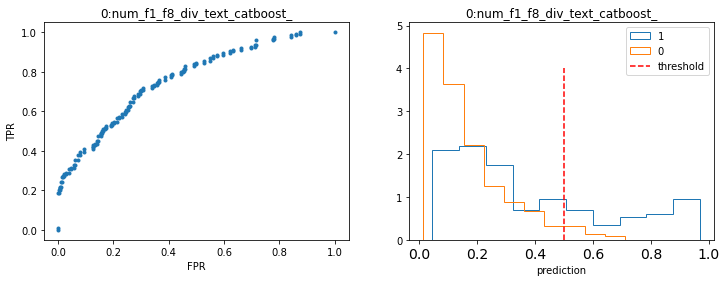

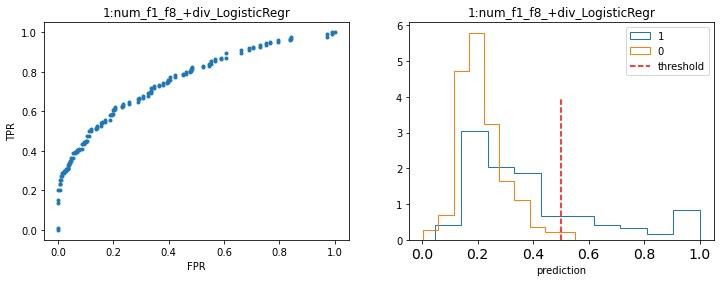

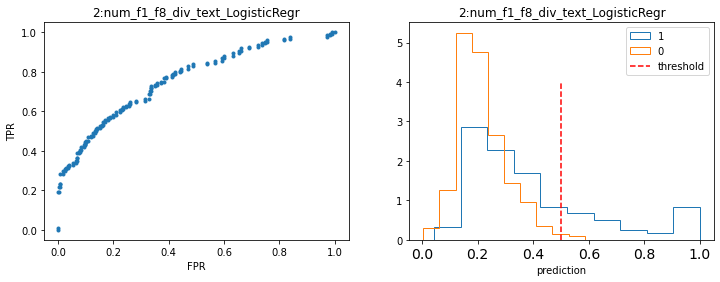

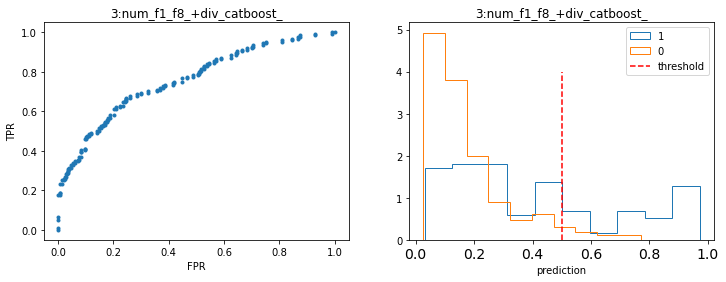

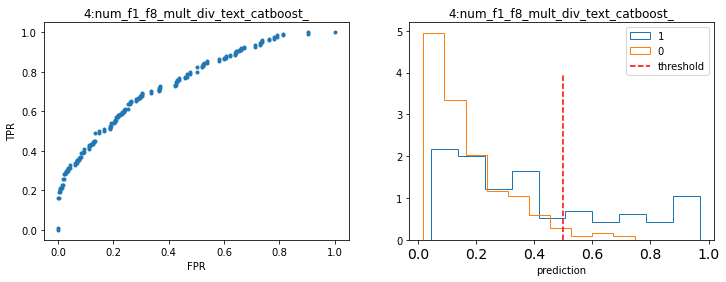

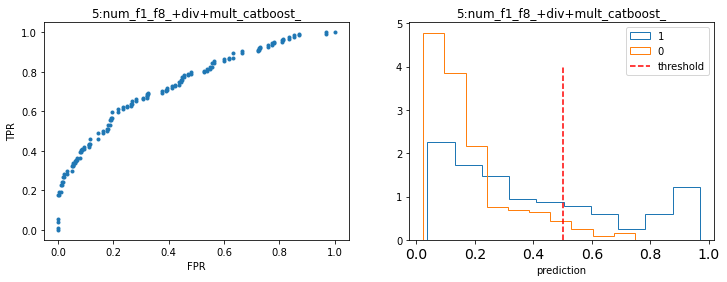

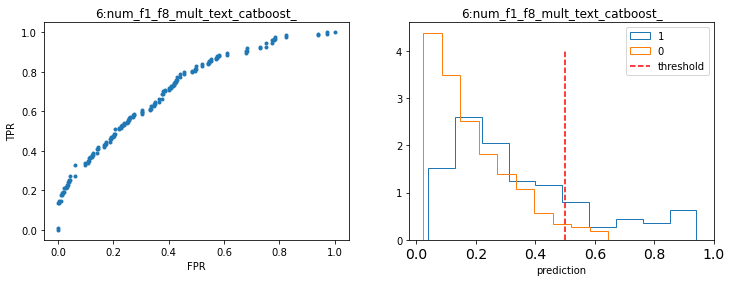

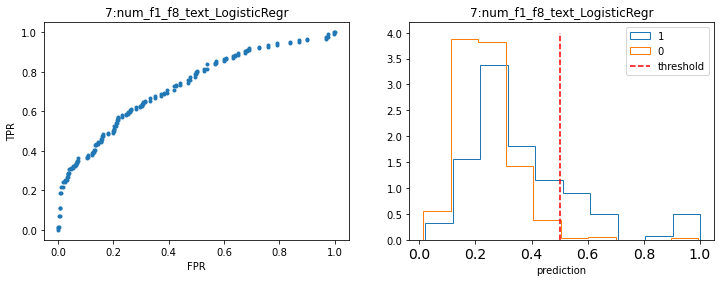

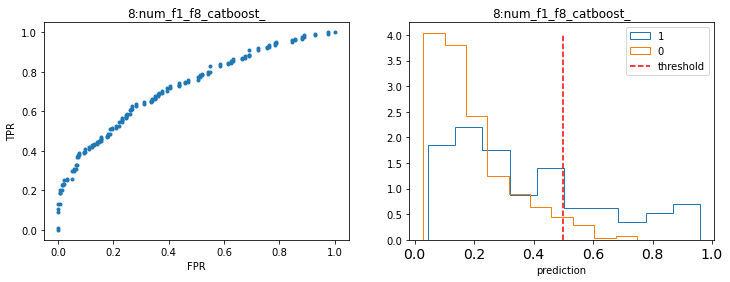

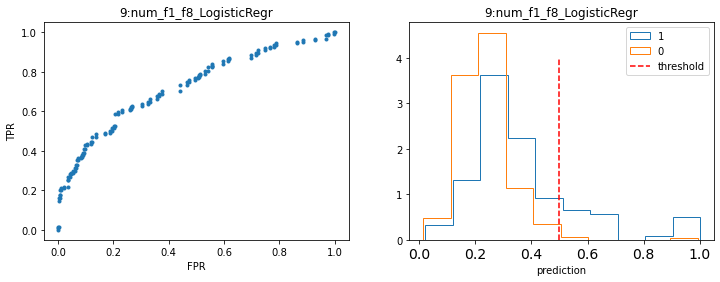

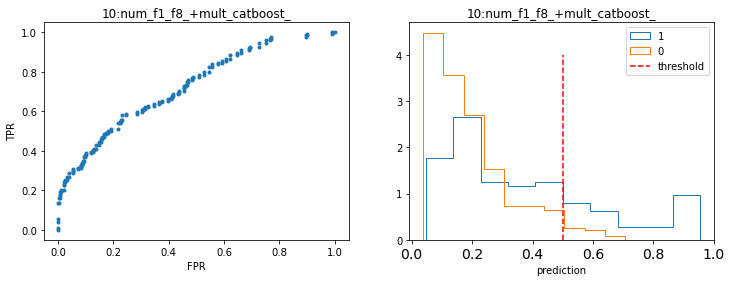

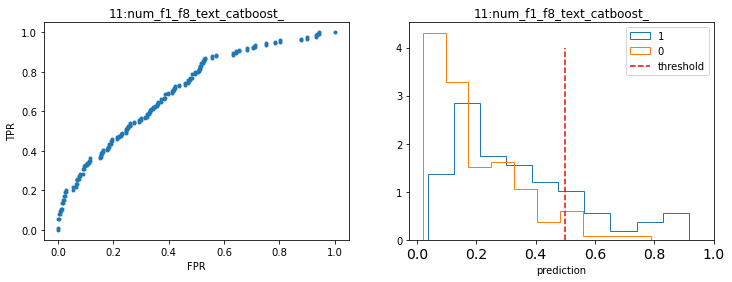

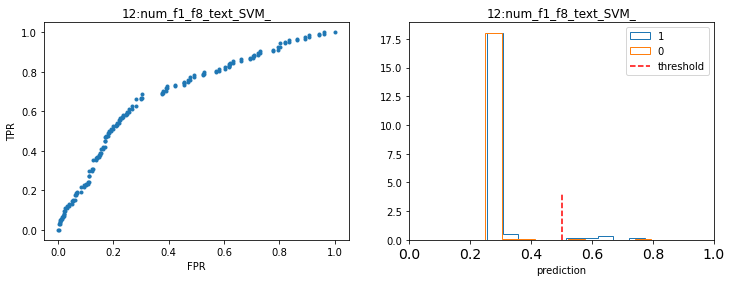

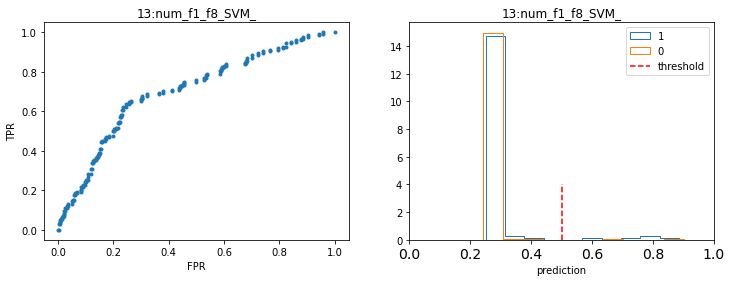

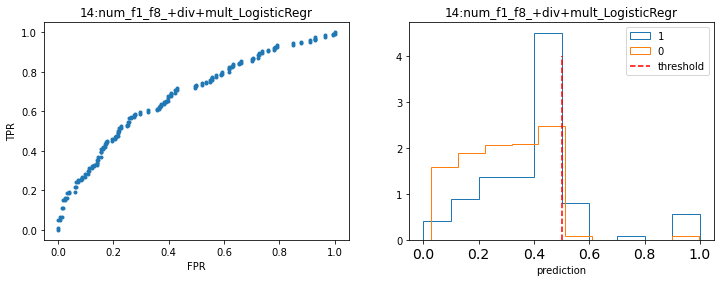

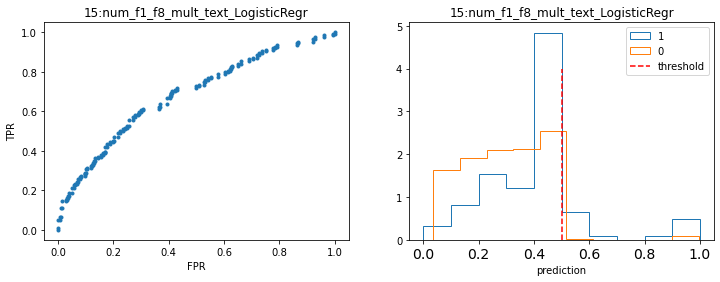

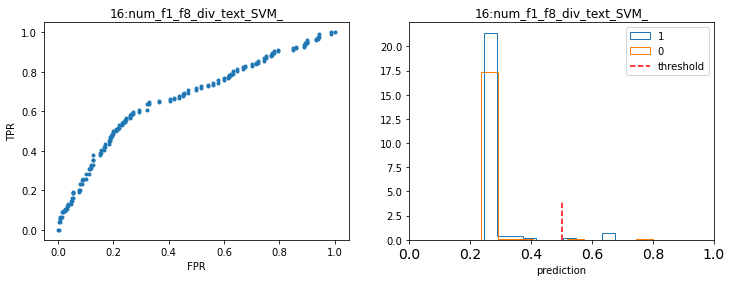

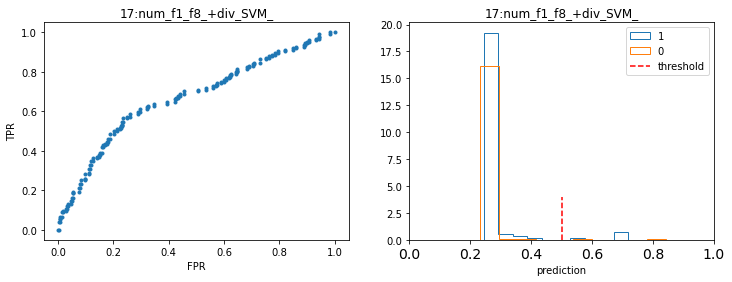

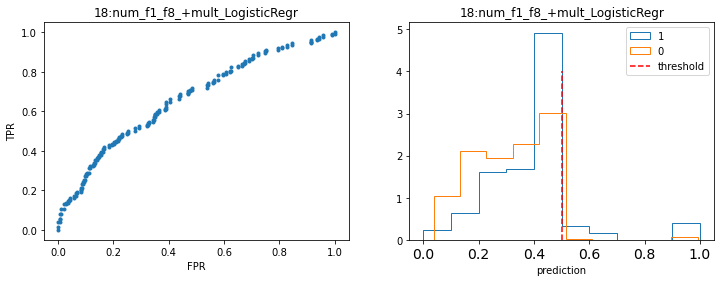

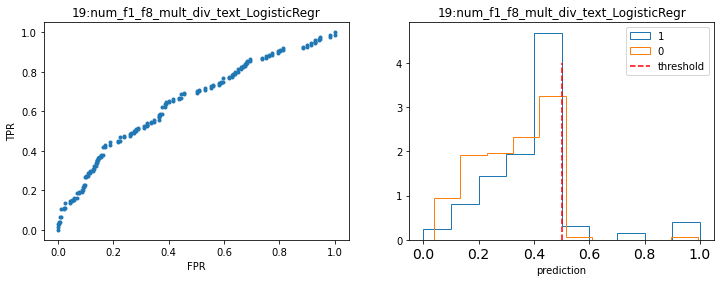

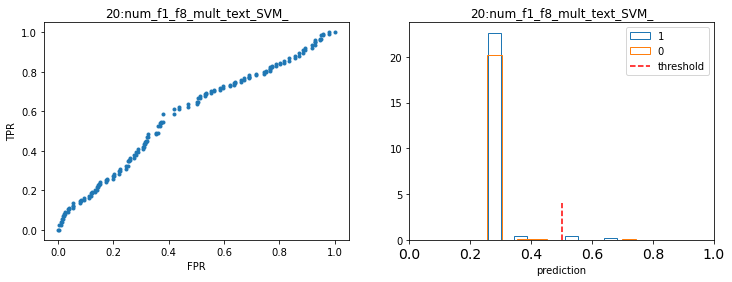

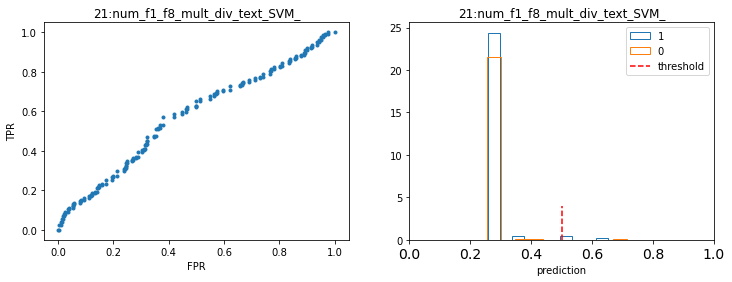

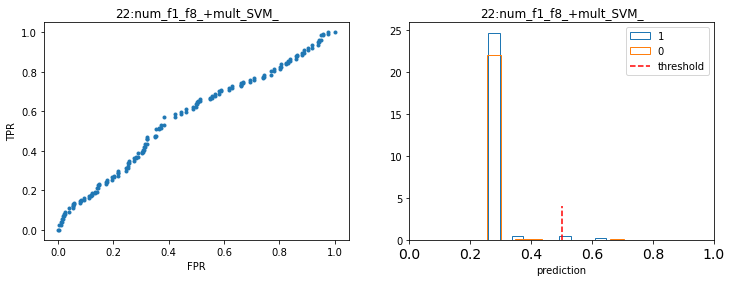

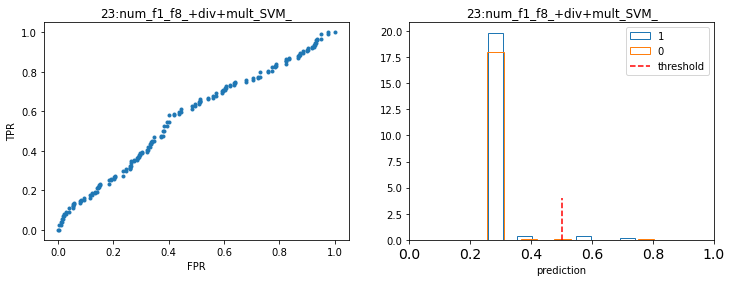

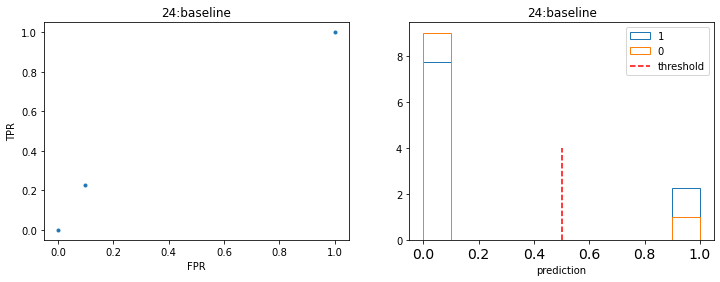

In [85]:
plot_results()

# 4. Обработка текста: Tf-idf без преобразований

In [86]:
data_text.head(2)

,text,label,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points
0,хотела купить на замену старых по итогу эти уж...,0,5,1,4.750000,16,0.062500,0.312500
1,запах по сравнению с обычным никакой оно не па...,1,2,3,5.642857,14,0.214286,0.142857


In [87]:
Tfidf_vect = TfidfVectorizer(max_features=2000)
_ = Tfidf_vect.fit_transform(data_text['text']).toarray()

text = Tfidf_vect.transform(data_text.text).toarray()
text = pd.DataFrame(text)

In [88]:
text.columns = list(map(str, ['text'+str(i) +'a' for i in range(1, text.shape[1] + 1)]))
text

,text1a,text2a,text3a,text4a,text5a,text6a,text7a,text8a,text9a,text10a,...,text1991a,text1992a,text1993a,text1994a,text1995a,text1996a,text1997a,text1998a,text1999a,text2000a
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
data_text = pd.concat([data_text, text], axis=1)

In [90]:
data_text.head(2)

,text,label,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points,text1a,text2a,...,text1991a,text1992a,text1993a,text1994a,text1995a,text1996a,text1997a,text1998a,text1999a,text2000a
0,хотела купить на замену старых по итогу эти уж...,0,5,1,4.750000,16,0.062500,0.312500,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,запах по сравнению с обычным никакой оно не па...,1,2,3,5.642857,14,0.214286,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
len((list(data_text.columns)))

2008

## 4.1 Добавление текста к f1-f8 и их делению

In [92]:
data = pd.concat([data_div, data_text.drop(['text', 'label'], axis=1)], axis=1)
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_div_text_tf_idf', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


## 4.2 Добавление текста к f1-f8, делению и умножению

In [93]:
data = pd.concat([data_mult_div, data_text.drop(['text', 'label'], axis=1)], axis=1)
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_mult_div_text_tf_idf', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


In [94]:
results = results.sort_values(by=['roc_auc', 'precision', 'f1'], ascending=False)
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
19,num_f1_f8_div_text_catboost_,0.784188,0.734694,0.290323,0.416185,0.767254,0.534509,0.5,"[0.07763154105923349, 0.05122071709279499, 0.1..."
9,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."
21,num_f1_f8_div_text_LogisticRegr,0.801282,0.918919,0.274194,0.422360,0.765309,0.530617,0.5,"[0.18258673074754028, 0.04887536756811502, 0.2..."
7,num_f1_f8_+div_catboost_,0.784188,0.709091,0.314516,0.435754,0.759143,0.518286,0.5,"[0.09426697959804306, 0.18868648292749332, 0.1..."
22,num_f1_f8_mult_div_text_catboost_,0.790598,0.770833,0.298387,0.430233,0.758205,0.516410,0.5,"[0.06739737745760196, 0.06918164586061212, 0.1..."
28,num_f1_f8_mult_div_text_tf_idf_catboost_,0.792735,0.800000,0.290323,0.426036,0.750914,0.501829,0.5,"[0.13516553918451754, 0.10337930565937614, 0.1..."
10,num_f1_f8_+div+mult_catboost_,0.784188,0.701754,0.322581,0.441989,0.749977,0.499953,0.5,"[0.12536026710700157, 0.22494989469870916, 0.1..."
25,num_f1_f8_div_text_tf_idf_catboost_,0.792735,0.813953,0.282258,0.419162,0.748758,0.497515,0.5,"[0.12797648819226357, 0.08492883312118096, 0.1..."
16,num_f1_f8_mult_text_catboost_,0.769231,0.700000,0.225806,0.341463,0.730542,0.461084,0.5,"[0.06473440942019575, 0.05804089007519713, 0.0..."
15,num_f1_f8_text_LogisticRegr,0.779915,0.862069,0.201613,0.326797,0.730237,0.460474,0.5,"[0.2313980928890961, 0.05905394025326441, 0.20..."


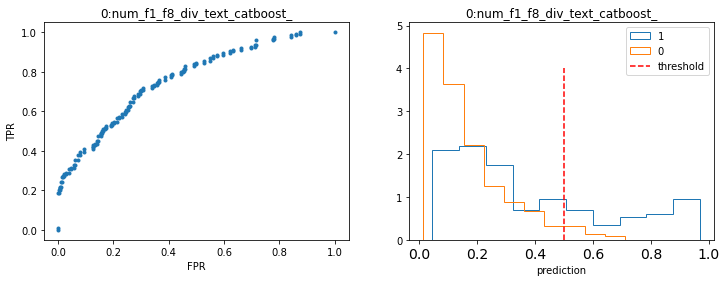

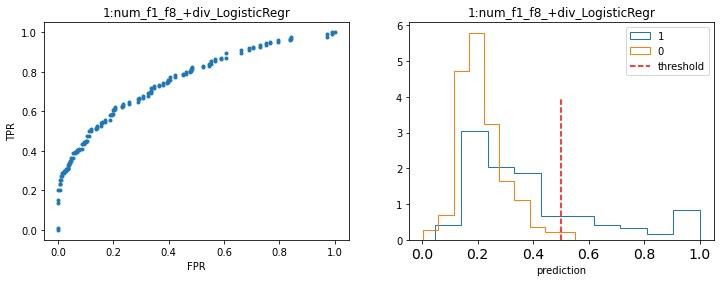

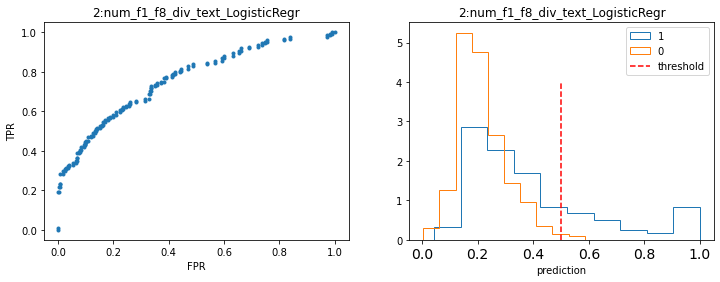

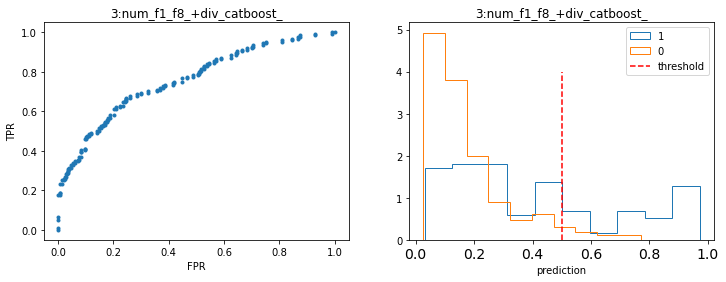

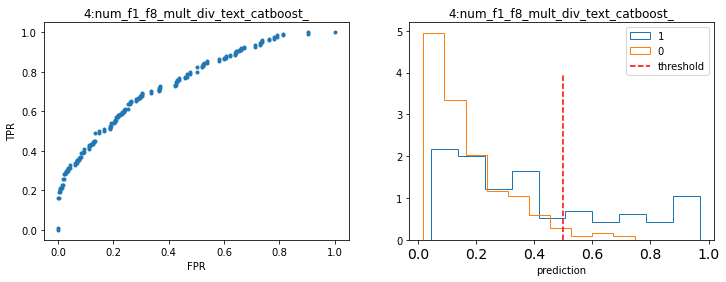

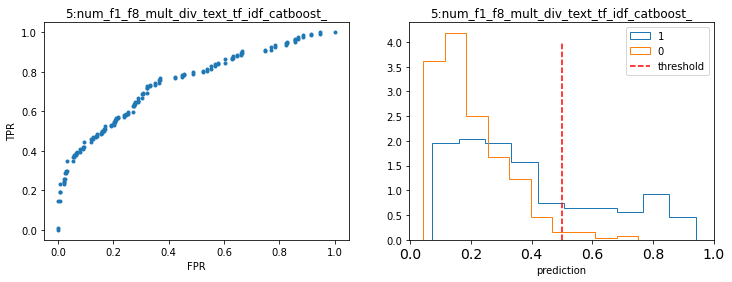

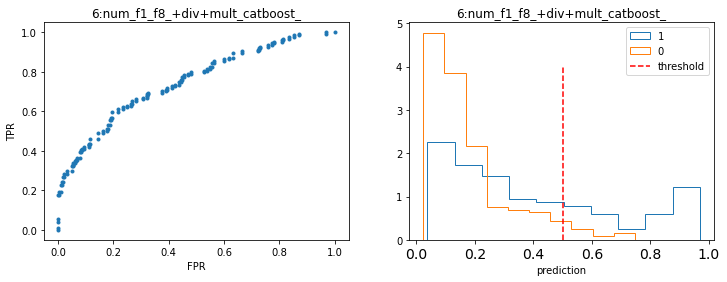

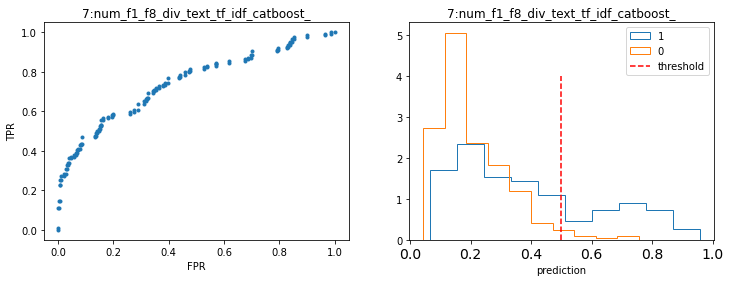

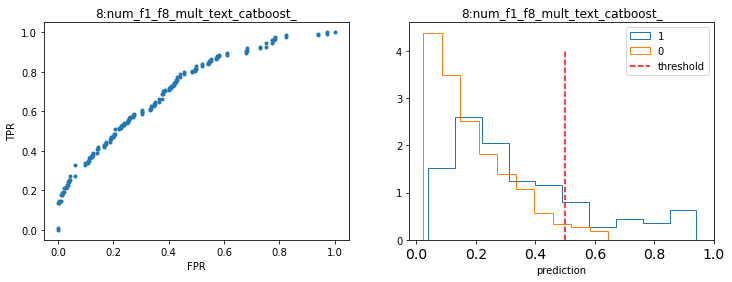

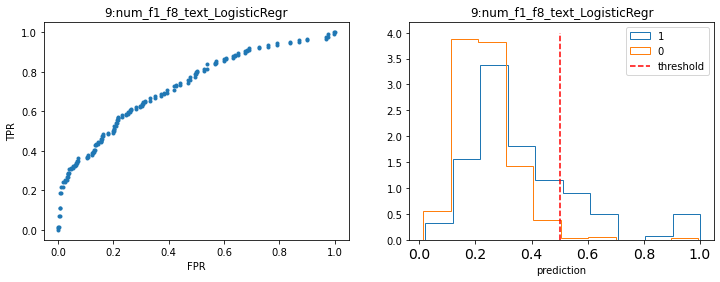

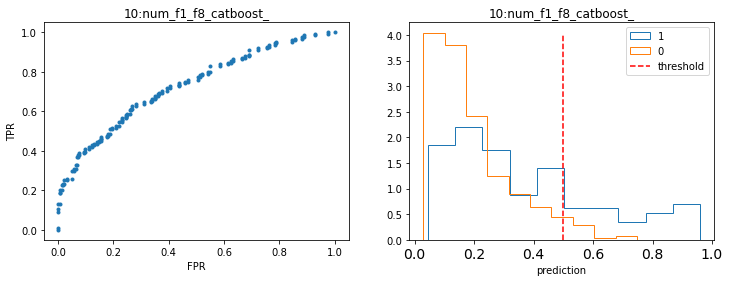

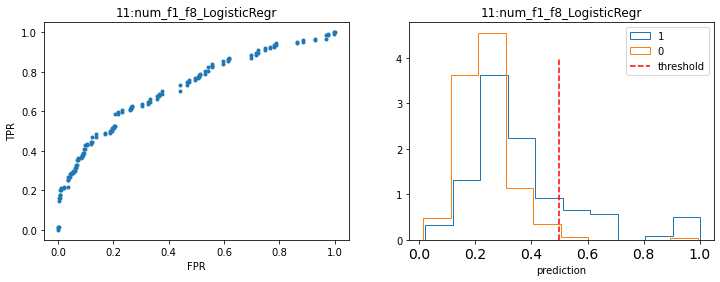

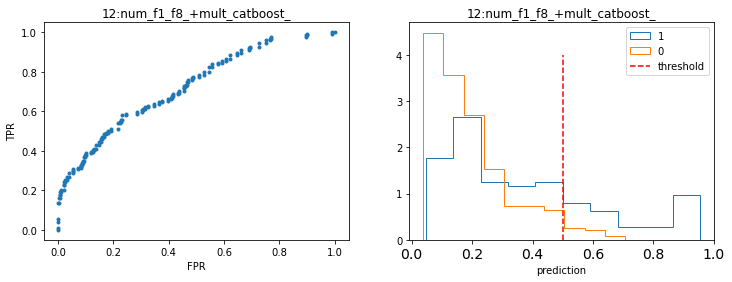

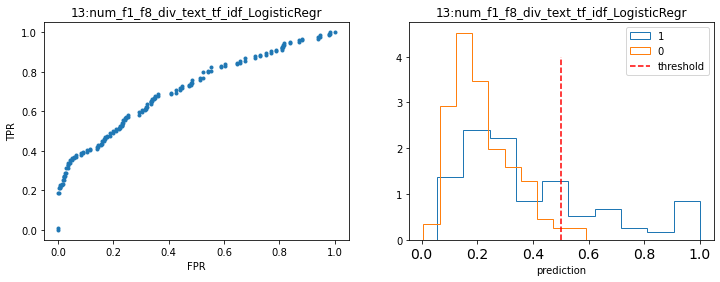

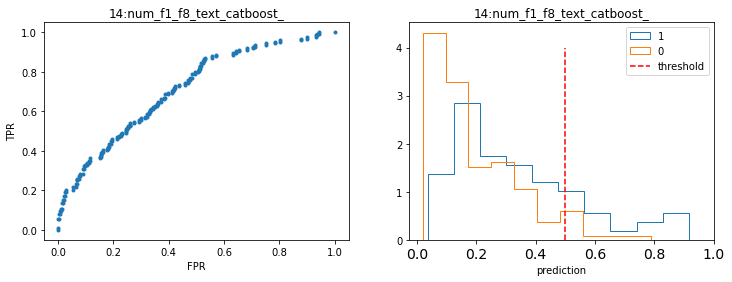

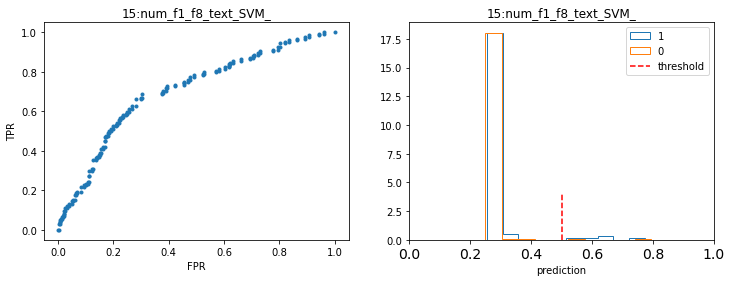

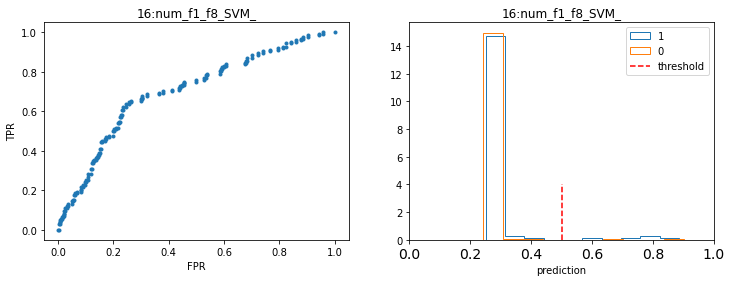

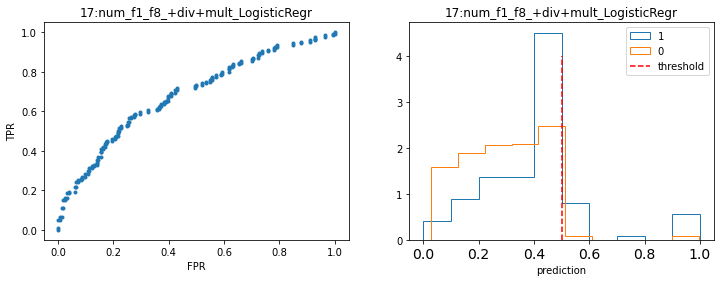

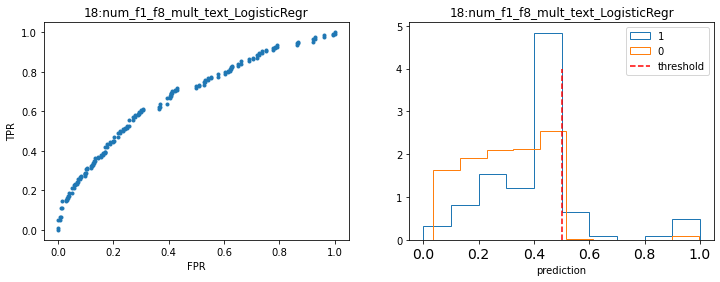

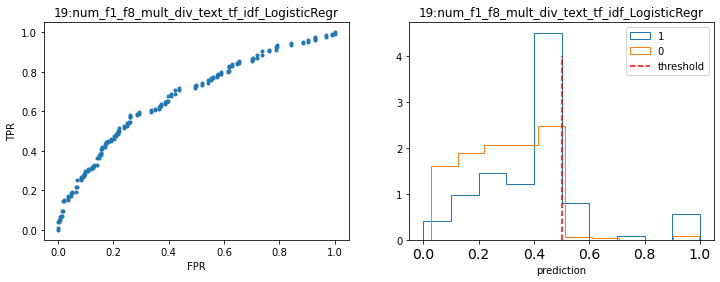

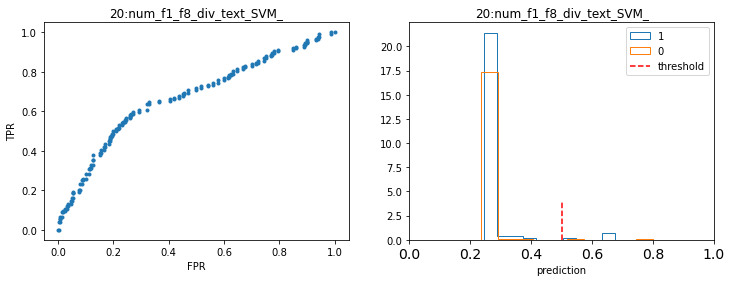

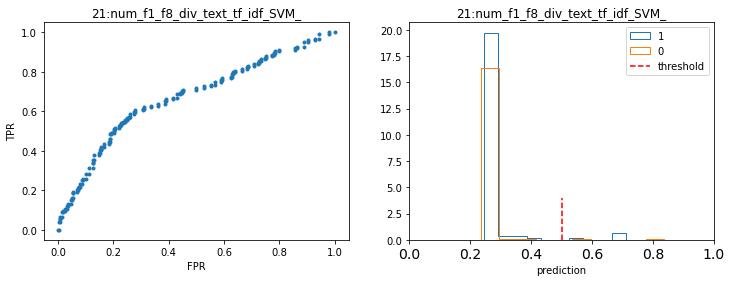

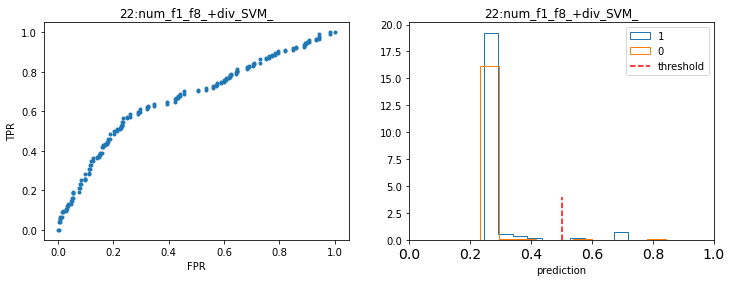

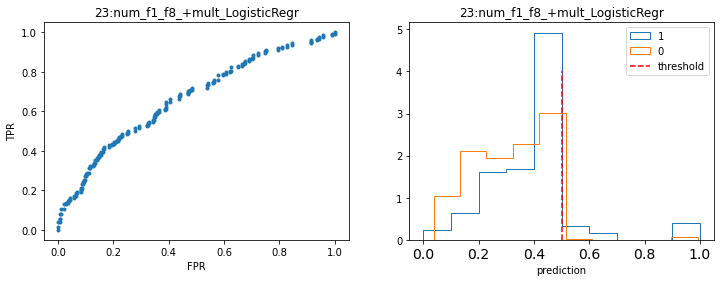

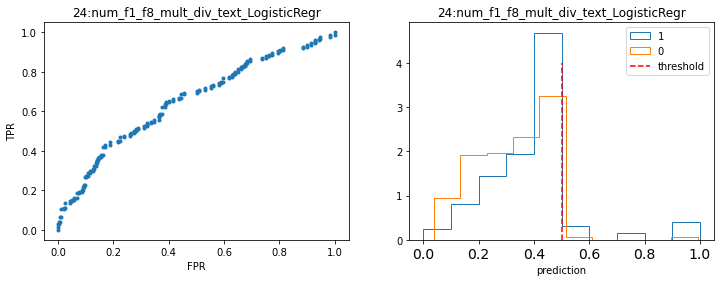

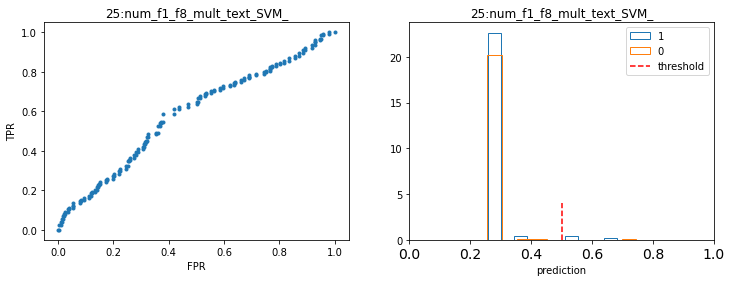

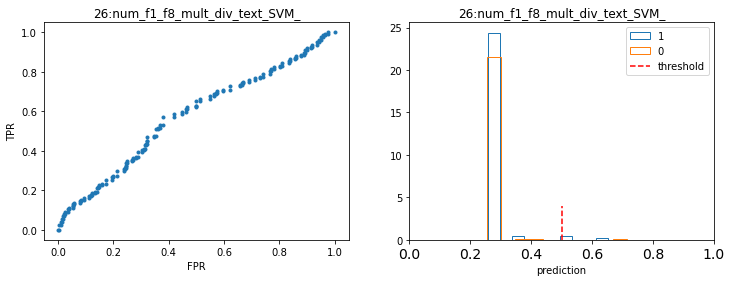

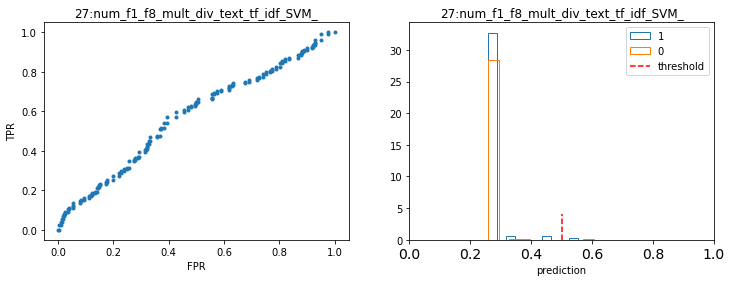

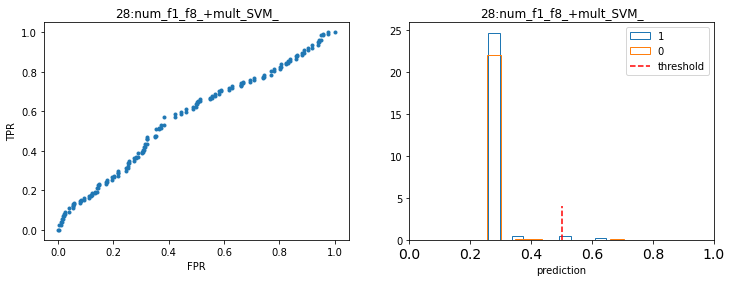

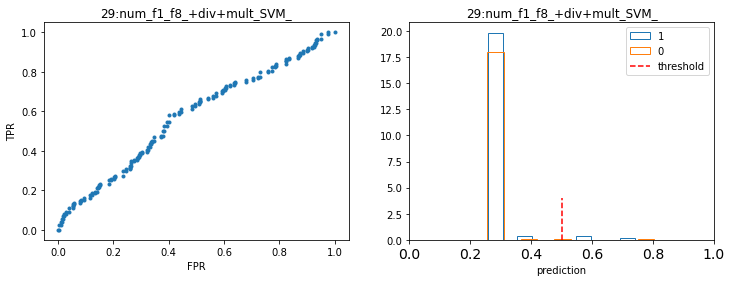

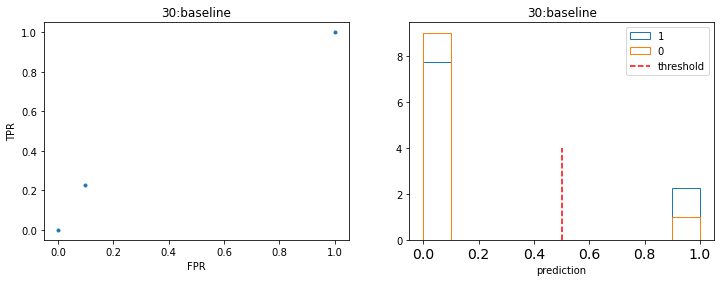

In [95]:
plot_results()

# 5. Обработка текста: BERT без преобразований

In [96]:
data_text = data_text1.copy()
data_text.head(2)

,text,label,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points
0,хотела купить на замену старых по итогу эти уж...,0,5,1,4.750000,16,0.062500,0.312500
1,запах по сравнению с обычным никакой оно не па...,1,2,3,5.642857,14,0.214286,0.142857


In [97]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
bert_model = BertModel.from_pretrained("bert-base-multilingual-uncased")
def tokenize_text(df, max_seq_length):
    return [
        tokenizer.encode(str(text), add_special_tokens=True)[:max_seq_length] for text in df.text.values
    ]


def pad_text(tokenized_text, max_seq_length):
    return np.array([el + [0] * (max_seq_length - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq_length):
    tokenized_text = tokenize_text(df, max_seq_length)
    padded_text = pad_text(tokenized_text, max_seq_length)
    return torch.tensor(padded_text)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
max_seq_length = 40
indices = tokenize_and_pad_text(data, max_seq_length)

In [99]:
with torch.no_grad():
    text = bert_model(indices)[0][:,0,:]

In [100]:
text = pd.DataFrame(text)
text.columns = list(map(str, ['text'+str(i) +'a' for i in range(1, text.shape[1] + 1)])) 

In [101]:
data_text = pd.concat([data_text, text], axis=1)

In [104]:
data_text.head(2)

,text,label,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points,text1a,text2a,...,text759a,text760a,text761a,text762a,text763a,text764a,text765a,text766a,text767a,text768a
0,хотела купить на замену старых по итогу эти уж...,0,5,1,4.750000,16,0.062500,0.312500,-0.246678,-0.037621,...,-0.049781,-0.155047,-0.726472,0.209908,-0.343622,0.007133,-0.612281,-0.270286,0.476395,-0.557829
1,запах по сравнению с обычным никакой оно не па...,1,2,3,5.642857,14,0.214286,0.142857,-0.093038,-0.060791,...,-0.006267,2.124445,-0.077657,-0.085017,0.025238,0.038080,-0.200306,-0.019575,-0.072583,-0.011476


## 5.1 Добавление текста к  f1-f8 и делению

In [105]:
data = pd.concat([data_div, data_text.drop(['text', 'label'], axis=1)], axis=1)
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_div_text_BERT', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


## 5.2 Добавление текста к f1-f8, делению и умножению

In [106]:
data = pd.concat([data_mult_div, data_text.drop(['text', 'label'], axis=1)], axis=1)
data_bert = data.copy()
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_f1_f8_mult_div_text_BERT', X_train, y_train, X_val, y_val)

---Catboost---
---SVM---
---Logistic regression---


# 

In [107]:
results_checkpoint = results.copy()
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
19,num_f1_f8_div_text_catboost_,0.784188,0.734694,0.290323,0.416185,0.767254,0.534509,0.5,"[0.07763154105923349, 0.05122071709279499, 0.1..."
9,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."
21,num_f1_f8_div_text_LogisticRegr,0.801282,0.918919,0.274194,0.422360,0.765309,0.530617,0.5,"[0.18258673074754028, 0.04887536756811502, 0.2..."
7,num_f1_f8_+div_catboost_,0.784188,0.709091,0.314516,0.435754,0.759143,0.518286,0.5,"[0.09426697959804306, 0.18868648292749332, 0.1..."
22,num_f1_f8_mult_div_text_catboost_,0.790598,0.770833,0.298387,0.430233,0.758205,0.516410,0.5,"[0.06739737745760196, 0.06918164586061212, 0.1..."
28,num_f1_f8_mult_div_text_tf_idf_catboost_,0.792735,0.800000,0.290323,0.426036,0.750914,0.501829,0.5,"[0.13516553918451754, 0.10337930565937614, 0.1..."
10,num_f1_f8_+div+mult_catboost_,0.784188,0.701754,0.322581,0.441989,0.749977,0.499953,0.5,"[0.12536026710700157, 0.22494989469870916, 0.1..."
25,num_f1_f8_div_text_tf_idf_catboost_,0.792735,0.813953,0.282258,0.419162,0.748758,0.497515,0.5,"[0.12797648819226357, 0.08492883312118096, 0.1..."
16,num_f1_f8_mult_text_catboost_,0.769231,0.700000,0.225806,0.341463,0.730542,0.461084,0.5,"[0.06473440942019575, 0.05804089007519713, 0.0..."
15,num_f1_f8_text_LogisticRegr,0.779915,0.862069,0.201613,0.326797,0.730237,0.460474,0.5,"[0.2313980928890961, 0.05905394025326441, 0.20..."


In [112]:
# так как результаты roc_auc примерно похожие, выберем лучшие модели и модель _BERT как модель с самым большим количеством признаков
mods = ['num_f1_f8_+div_LogisticRegr', 'num_f1_f8_div_text_catboost_', 'num_f1_f8_div_text_LogisticRegr',
       'num_f1_f8_mult_div_text_BERT_catboost_']

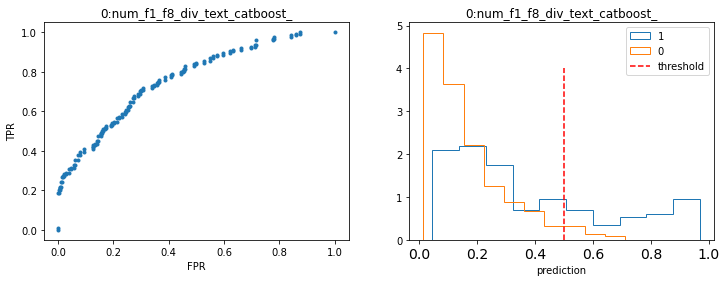

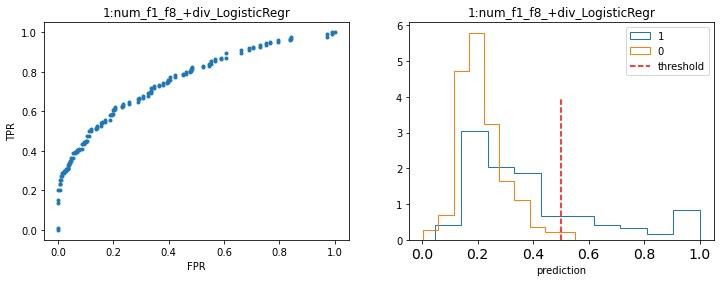

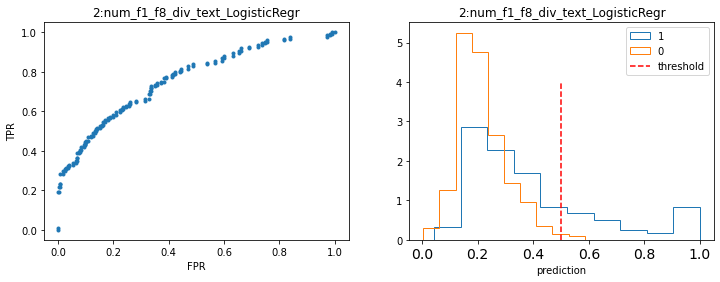

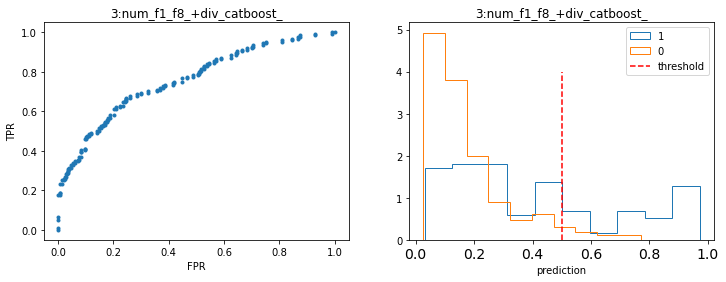

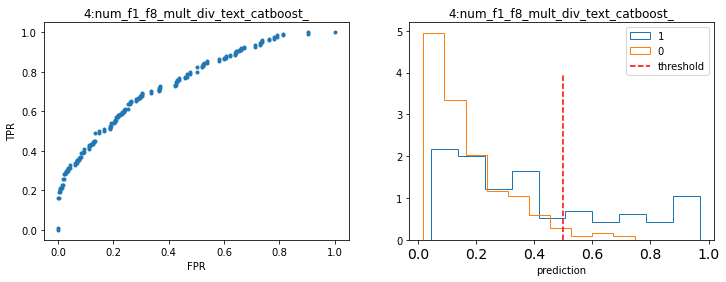

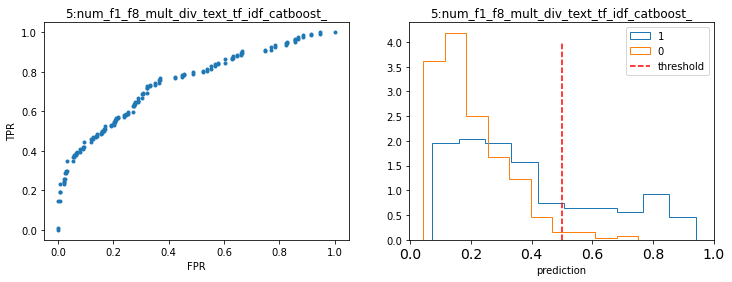

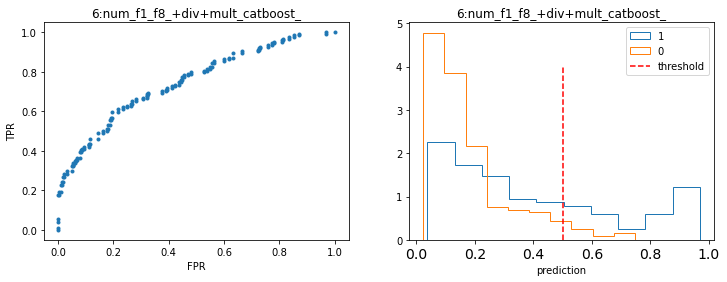

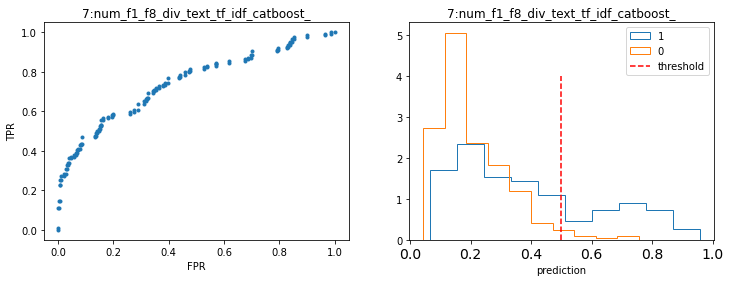

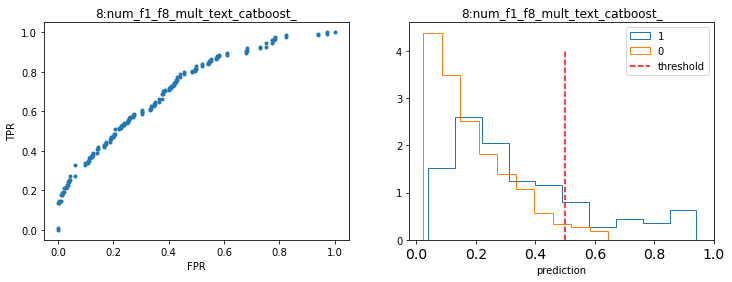

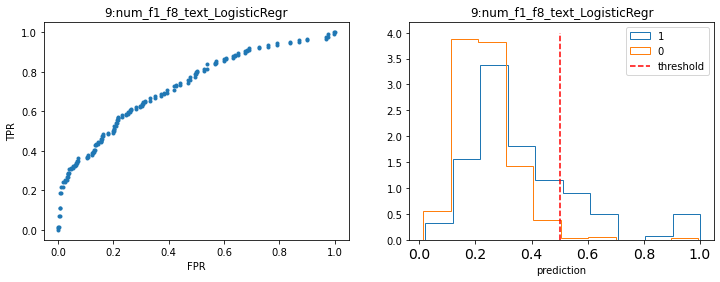

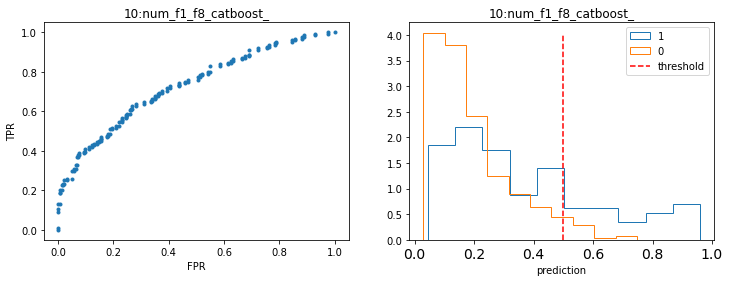

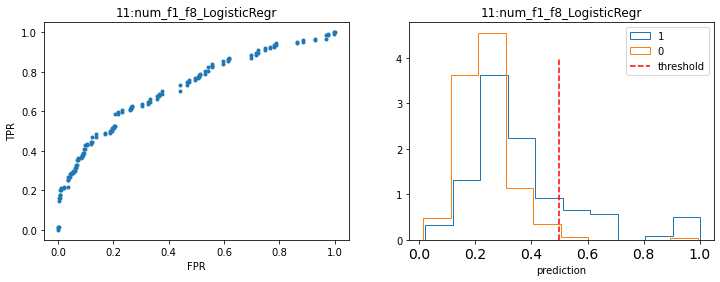

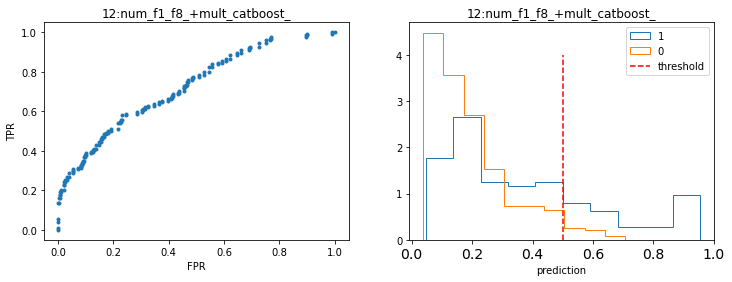

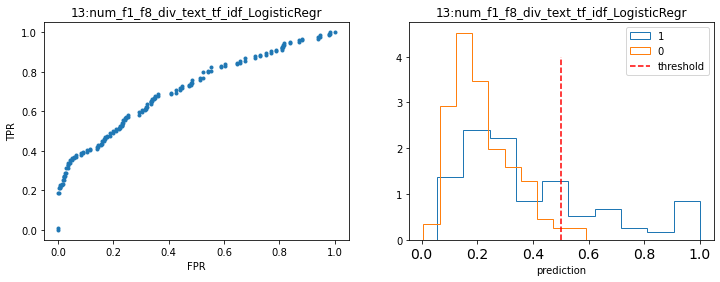

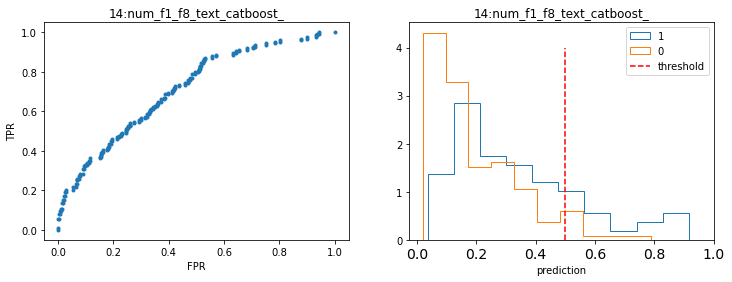

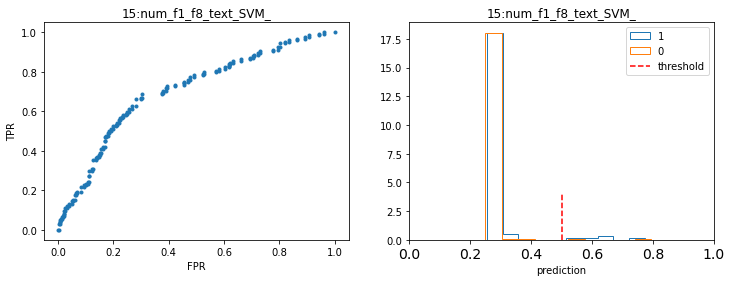

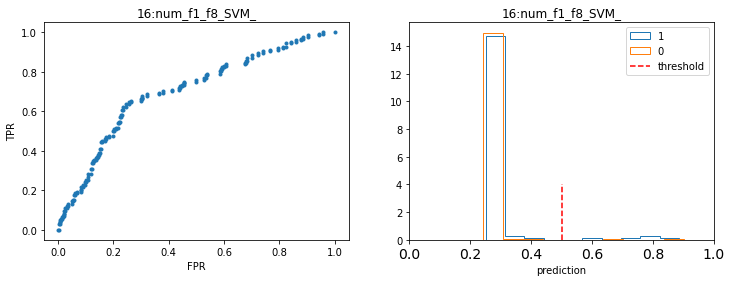

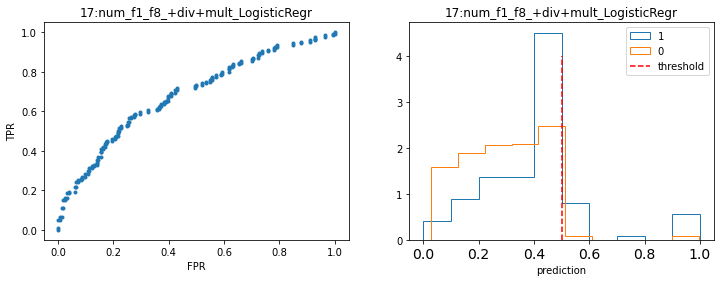

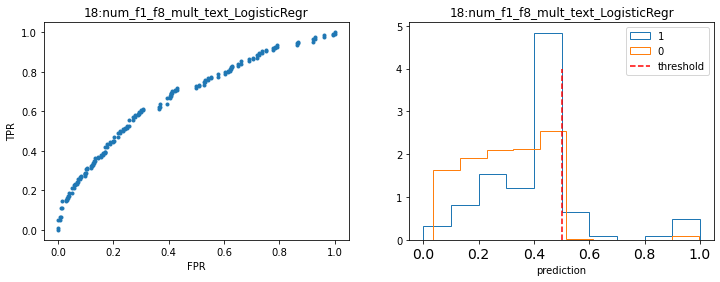

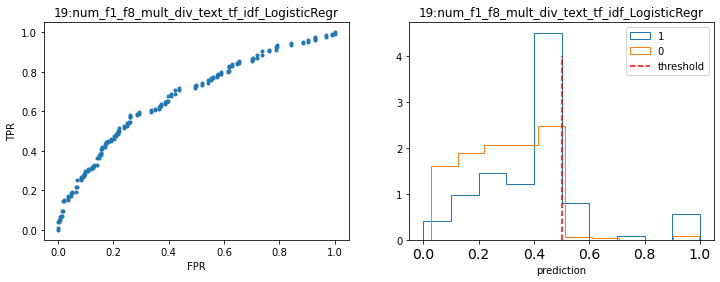

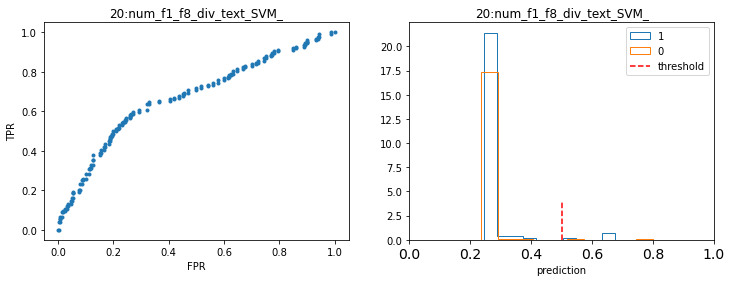

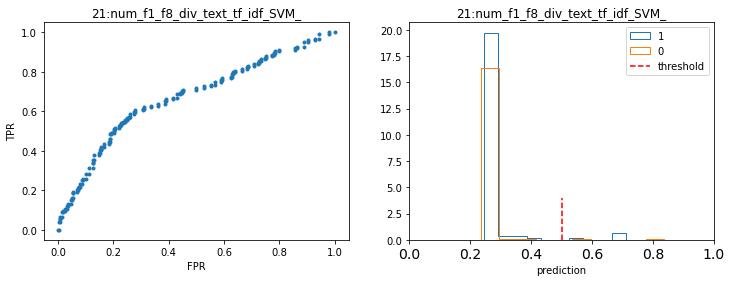

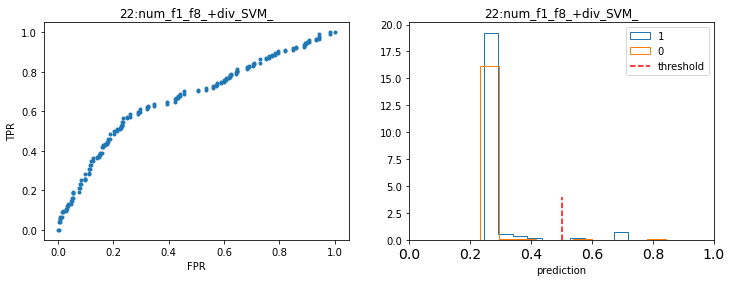

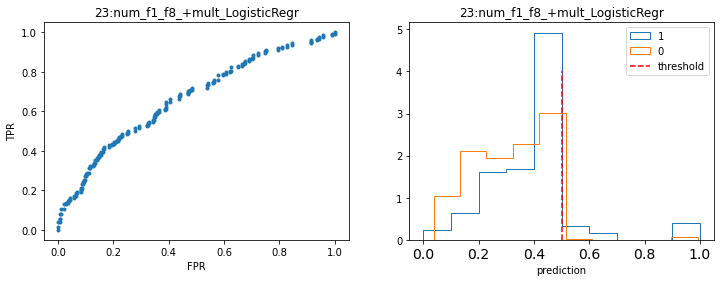

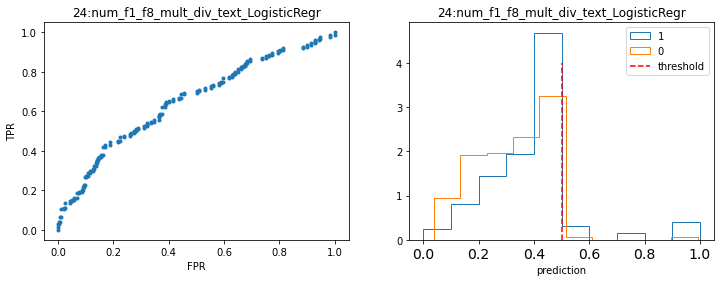

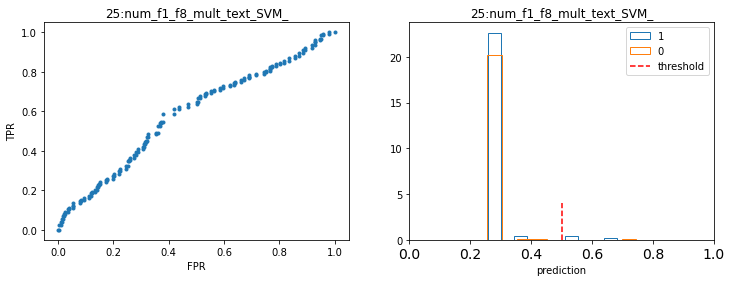

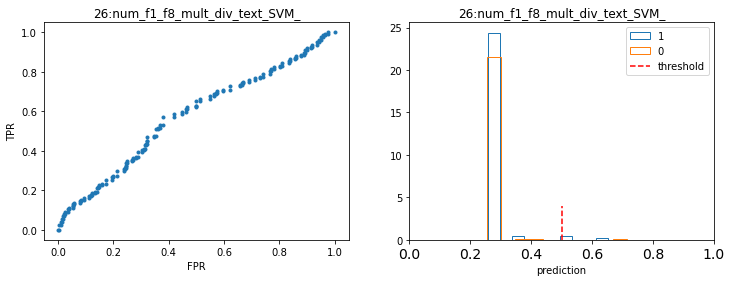

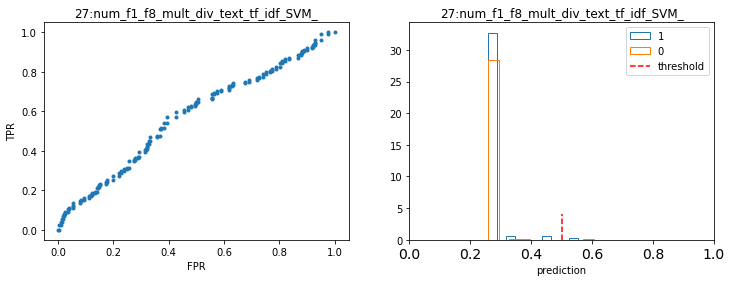

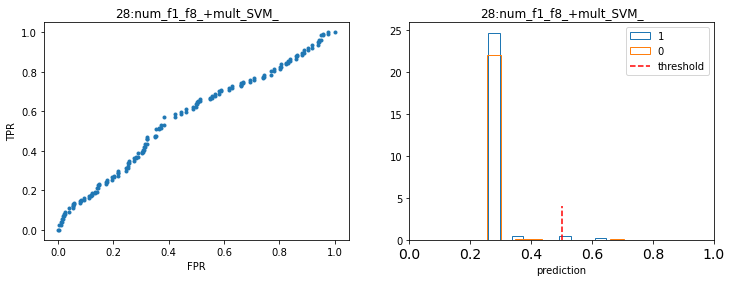

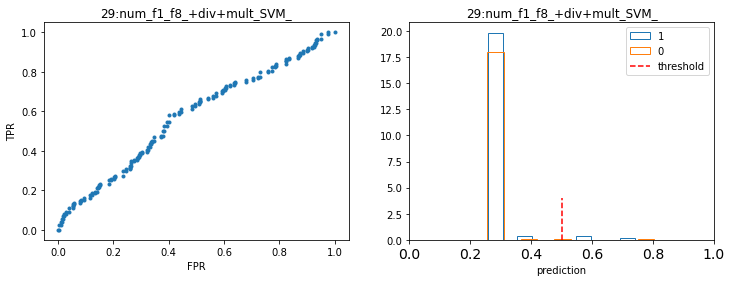

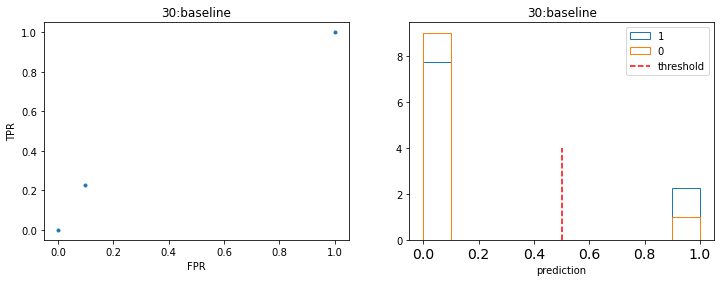

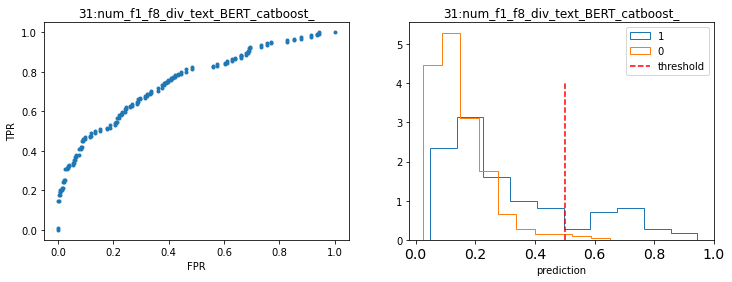

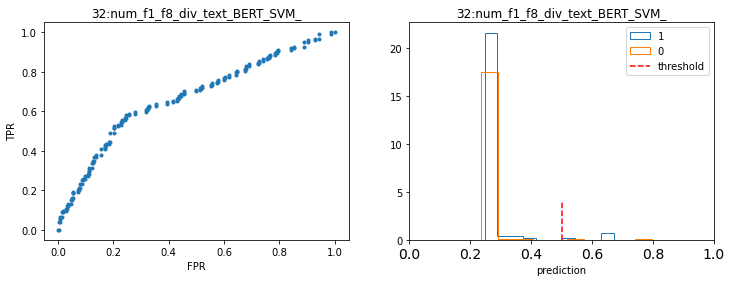

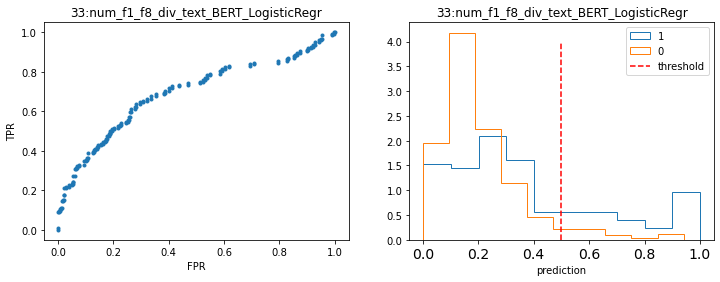

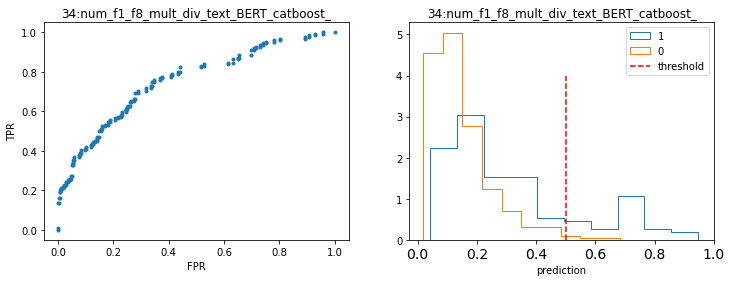

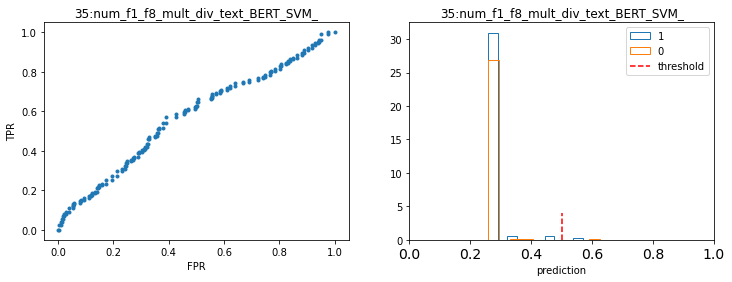

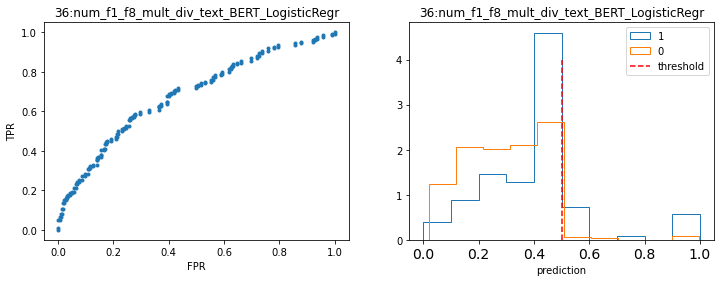

In [109]:
plot_results()

In [157]:
results = results_checkpoint

# 6. Анализ результатов (threshold)

In [158]:
# выделим только выбранные модели
def tmp(x):
    if x in mods:
        return 1
    return 0

best = results[results.model.apply(tmp) == 1].reset_index(drop=True)

In [159]:
best

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_f1_f8_div_text_catboost_,0.784188,0.734694,0.290323,0.416185,0.767254,0.534509,0.5,"[0.07763154105923349, 0.05122071709279499, 0.1..."
1,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."
2,num_f1_f8_div_text_LogisticRegr,0.801282,0.918919,0.274194,0.422360,0.765309,0.530617,0.5,"[0.18258673074754028, 0.04887536756811502, 0.2..."
3,num_f1_f8_mult_div_text_BERT_catboost_,0.782051,0.892857,0.201613,0.328947,0.756752,0.513503,0.5,"[0.06054419523986704, 0.02158623190681155, 0.0..."


In [160]:
results = best.copy()

In [161]:
cols = results.columns
results = pd.DataFrame(np.array(results))
results.columns = cols

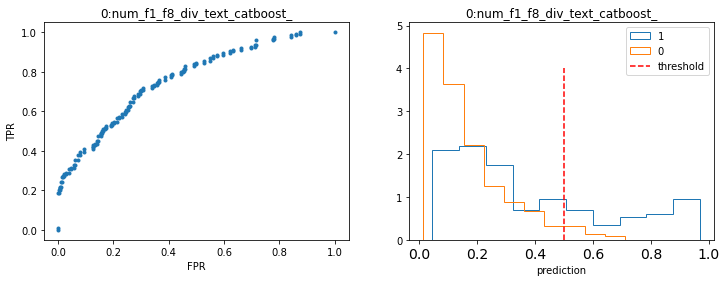

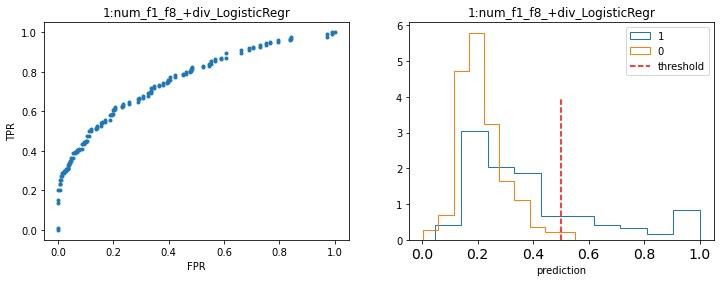

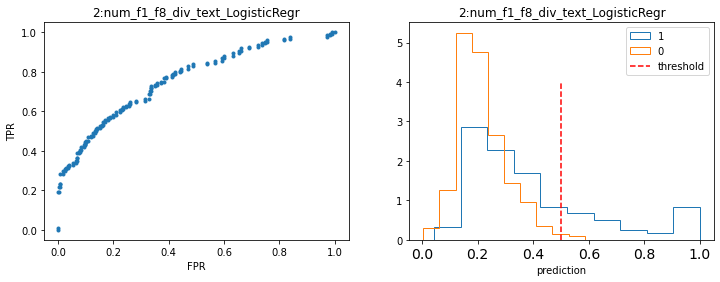

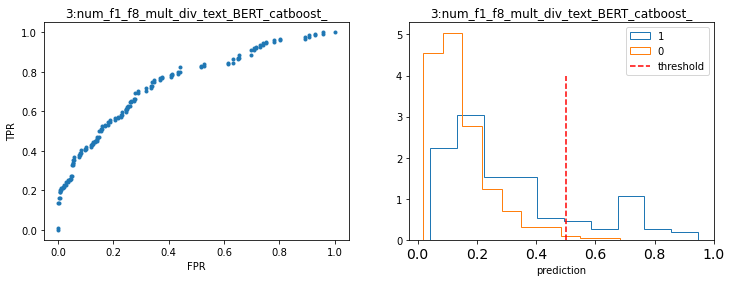

In [162]:
plot_results()

In [163]:
names = results.model.values
preds = results.predicted.values
thrs2=0.7

for i in range(len(results)):
#     evaluation(names[i], y_val, preds[i], thrs1)
    evaluation(names[i], y_val, preds[i], thrs2)

In [164]:
results = results.sort_values(by=['roc_auc', 'precision', 'f1'], ascending=False).reset_index()
results

,index,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,4,num_f1_f8_div_text_catboost_,0.784188,0.96,0.193548,0.322148,0.767254,0.534509,0.7,"[0.07763154105923349, 0.05122071709279499, 0.1..."
1,0,num_f1_f8_div_text_catboost_,0.784188,0.734694,0.290323,0.416185,0.767254,0.534509,0.5,"[0.07763154105923349, 0.05122071709279499, 0.1..."
2,5,num_f1_f8_+div_LogisticRegr,0.775641,1.0,0.153226,0.265734,0.765637,0.531273,0.7,"[0.18408155767528614, 0.052201304307361855, 0...."
3,1,num_f1_f8_+div_LogisticRegr,0.797009,0.891892,0.266129,0.409938,0.765637,0.531273,0.5,"[0.18408155767528614, 0.052201304307361855, 0...."
4,6,num_f1_f8_div_text_LogisticRegr,0.769231,1.0,0.129032,0.228571,0.765309,0.530617,0.7,"[0.18258673074754028, 0.04887536756811502, 0.2..."
5,2,num_f1_f8_div_text_LogisticRegr,0.801282,0.918919,0.274194,0.42236,0.765309,0.530617,0.5,"[0.18258673074754028, 0.04887536756811502, 0.2..."
6,7,num_f1_f8_mult_div_text_BERT_catboost_,0.764957,1.0,0.112903,0.202899,0.756752,0.513503,0.7,"[0.06054419523986704, 0.02158623190681155, 0.0..."
7,3,num_f1_f8_mult_div_text_BERT_catboost_,0.782051,0.892857,0.201613,0.328947,0.756752,0.513503,0.5,"[0.06054419523986704, 0.02158623190681155, 0.0..."


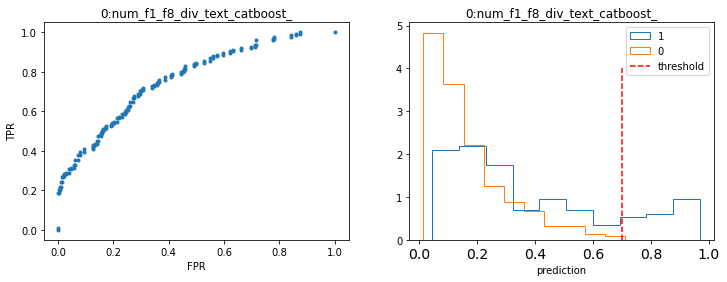

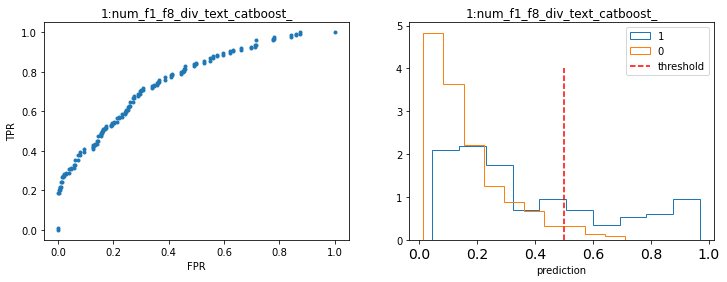

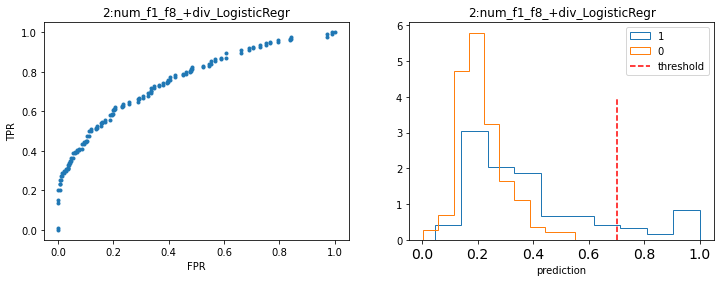

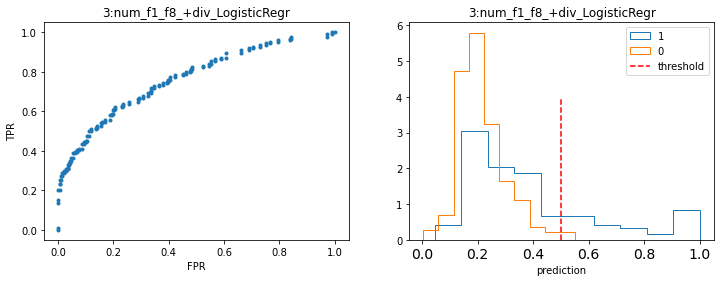

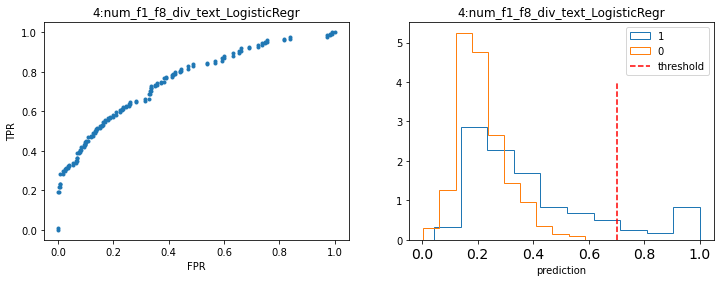

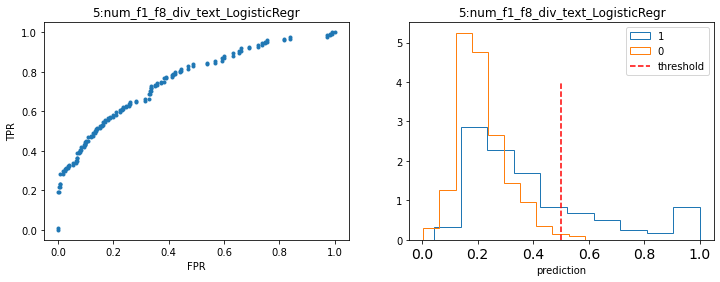

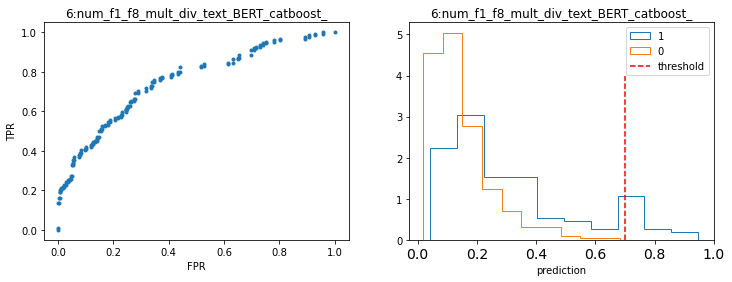

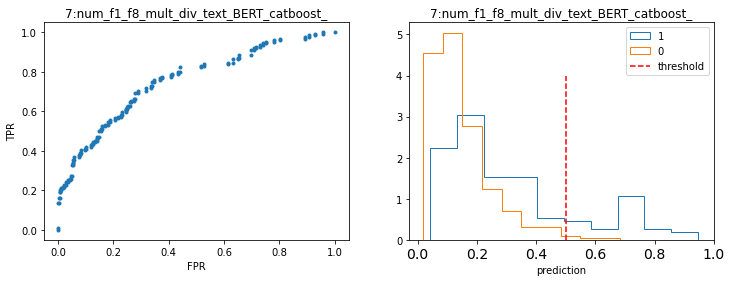

In [165]:
plot_results()

# Проверка на тесте выбранных моделей с порогом 0.7
Проверим, насколько хорошо обобщаются модели на "другие данные" (тестовая выборка)

In [166]:
# выделим только модели с thrs=0.7
best1 = results[results.thrs > 0.5]

In [167]:
results = best1.copy()
cols = results.columns
results = pd.DataFrame(np.array(results))
results.columns = cols

In [168]:
results.drop(['index'], axis=1, inplace=True)
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_f1_f8_div_text_catboost_,0.784188,0.96,0.193548,0.322148,0.767254,0.534509,0.7,"[0.07763154105923349, 0.05122071709279499, 0.1..."
1,num_f1_f8_+div_LogisticRegr,0.775641,1.0,0.153226,0.265734,0.765637,0.531273,0.7,"[0.18408155767528614, 0.052201304307361855, 0...."
2,num_f1_f8_div_text_LogisticRegr,0.769231,1.0,0.129032,0.228571,0.765309,0.530617,0.7,"[0.18258673074754028, 0.04887536756811502, 0.2..."
3,num_f1_f8_mult_div_text_BERT_catboost_,0.764957,1.0,0.112903,0.202899,0.756752,0.513503,0.7,"[0.06054419523986704, 0.02158623190681155, 0.0..."


Веса не сохранялись, поэтому придется заново обучить выбранные модели

1. num_f1_f8_+div_LogisticRegr	

In [169]:
data = data_div.copy()

In [170]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f2_f8,div_f3_f4,div_f3_f6,div_f3_f8,div_f4_f6,div_f4_f8,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,0.027778,0.090909,0.234043,0.027778,2.574468,0.305556,3.042553,0.361111,0.118687,0.500000
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,0.055046,0.058696,0.608824,0.024771,10.372549,0.422018,0.901961,0.036697,0.040686,0.825688


In [171]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label


In [172]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)
preds_proba = model.predict_proba(X_test)
preds_proba1 = preds_proba[:, 1]
evaluation('_TEST_num_f1_f8_+div_LogisticRegr', y_test, preds_proba1, thrs=0.7)  
# evaluation('_TEST_num_f1_f8_+div_LogisticRegr', y_test, preds_proba1, thrs=0.8) 

2. num_f1_f8_div_text_catboost_

In [173]:
data = pd.concat([data_div, data_text1.drop(['text', 'label'], axis=1)], axis=1)

In [174]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8,num_points,num_big_letters,avg_word_len,num_words,avg_big_letters,avg_points
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,3.042553,0.361111,0.118687,0.500000,5,1,4.750000,16,0.062500,0.312500
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,0.901961,0.036697,0.040686,0.825688,2,3,5.642857,14,0.214286,0.142857


In [175]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [176]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=10, silent=True)
model.fit(X_train, y_train)
preds_proba = model.predict_proba(X_test)
preds_proba1 = preds_proba[:, 1]
evaluation('_TEST_num_f1_f8_div_text_catboost', y_test, preds_proba1, 0.7)
# evaluation('_TEST_num_f1_f8_div_text_catboost', y_test, preds_proba1, 0.8)

3. num_f1_f8_div_text_LogisticRegr

In [177]:
data = pd.concat([data_div, data_text1.drop(['text', 'label'], axis=1)], axis=1)

In [178]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [179]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)
preds_proba = model.predict_proba(X_test)
preds_proba1 = preds_proba[:, 1]
evaluation('_TEST_num_f1_f8_div_text_LogisticRegr', y_test, preds_proba1, 0.7)
# evaluation('_TEST_num_f1_f8_div_text_LogisticRegr', y_test, preds_proba1, 0.8)

4. num_f1_f8_mult_div_text_BERT_catboost_

In [180]:
data = data_bert # данные с текстовыми фичами и берт

In [181]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [182]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=10, silent=True)
model.fit(X_train, y_train)
preds_proba = model.predict_proba(X_test)
preds_proba1 = preds_proba[:, 1]
evaluation('_TEST_num_f1_f8_mult_div_text_BERT_catboost_', y_test, preds_proba1, 0.7)
# evaluation('_TEST_num_f1_f8_mult_div_text_BERT_catboost_', y_test, preds_proba1, 0.8)

# 

In [183]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_f1_f8_div_text_catboost_,0.784188,0.96,0.193548,0.322148,0.767254,0.534509,0.7,"[0.07763154105923349, 0.05122071709279499, 0.1..."
1,num_f1_f8_+div_LogisticRegr,0.775641,1.0,0.153226,0.265734,0.765637,0.531273,0.7,"[0.18408155767528614, 0.052201304307361855, 0...."
2,num_f1_f8_div_text_LogisticRegr,0.769231,1.0,0.129032,0.228571,0.765309,0.530617,0.7,"[0.18258673074754028, 0.04887536756811502, 0.2..."
3,num_f1_f8_mult_div_text_BERT_catboost_,0.764957,1.0,0.112903,0.202899,0.756752,0.513503,0.7,"[0.06054419523986704, 0.02158623190681155, 0.0..."
4,_TEST_num_f1_f8_+div_LogisticRegr,0.754797,0.8,0.096774,0.172662,0.722253,0.444507,0.7,"[0.1652174601438864, 0.6792901826487155, 0.231..."
5,_TEST_num_f1_f8_div_text_catboost,0.776119,0.827586,0.193548,0.313725,0.736536,0.473072,0.7,"[0.1762056688151009, 0.5325843344550423, 0.236..."
6,_TEST_num_f1_f8_div_text_LogisticRegr,0.754797,0.8,0.096774,0.172662,0.732609,0.465217,0.7,"[0.1623235218997809, 0.6847925380072734, 0.175..."
7,_TEST_num_f1_f8_mult_div_text_BERT_catboost_,0.759062,0.789474,0.120968,0.20979,0.717485,0.43497,0.7,"[0.07807331495912571, 0.3223880582660972, 0.14..."


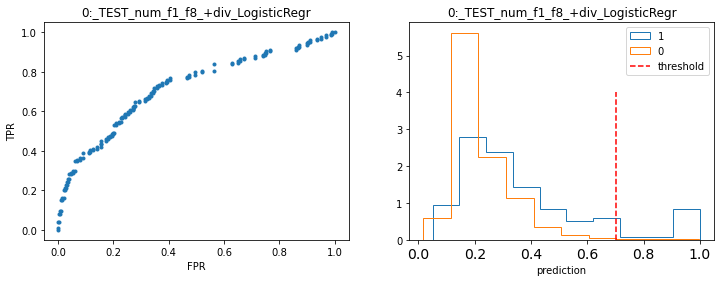

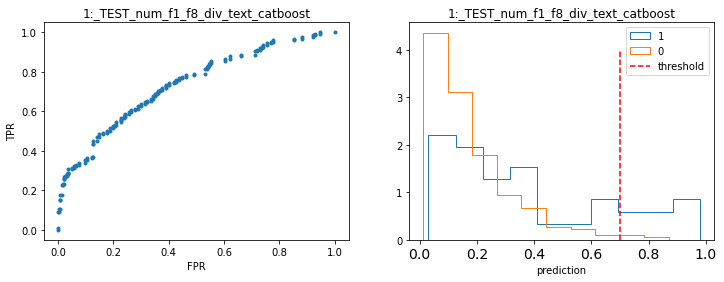

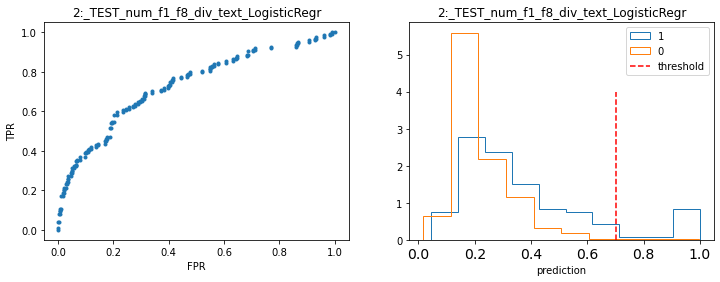

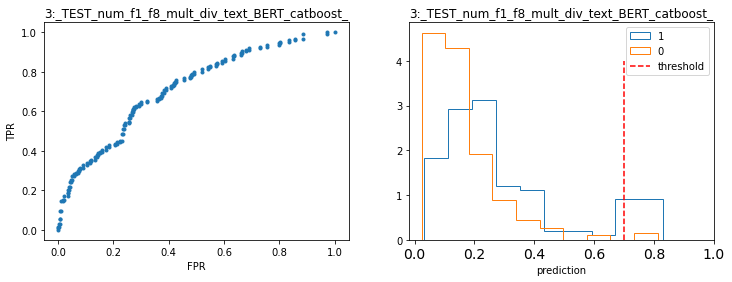

In [185]:
preds = results.predicted.values[4:]
name = results.model.values[4:]
thrs = results.thrs.values[4:]
for i in range(len(thrs)):
    plot(str(i) + ':' + name[i], preds[i], y_test, thrs[i])

In [186]:
# без калибровки гиперпараметров нельзя выбрать модель

# Вывод: 
обработка текста (BERT) не дала преимущества

по представленным результатам (максимизируем precision и f1), следующим шагом будет подбор параметров 
для моделей логистической регрессии и catboost для следующих типов данных: 

числовые + деление + текстовые признаки  

числовые + деление